# Wedge Project Material Stock Projection - Approach 1: Time Series Regression
This Jupyter notebook uses two approaches for projecting material stocks until 2050 in the US building and infrastructure sectors.
1. **Approach 1** uses historic material consumption data and ARIMA/SARIMA time series moving average models to project material consumptions. Historic data is mostly obtained from USGS for raw building material ingredients (e.g., cement, steel, lime, etc.)
2. **Approach 2** uses floor area projections (for buildings, and possibly for infrastructure) and material intensity data to project material consumptions. Building-level data is primarily available per building material categories (e.g., concrete, steel, rebar, bricks, etc.)

Each approach uses a different set of input data and modeling principles with certain scopes according to the granularity and scope of available data.

Python scripts are developed to clean and organize input data, perform calculations, and export modeling results. Descriptions are also provided whenever necessary.

## Import libraries

In [1]:
import pandas as pd
import plotly.express as px
import os
import warnings

## Import Wedge Project dataset templates

There are four major datasets used here:
1. **material_intensity**: Kg of material (or material category) used per square meter and per building/project type. CLF WBLCA benchmarking study data is the primary source.
2. **floor_area**: Square meter of gross floor area (either projected or historic) per building type or primary use. **NOTE:** this is total floor area. For material stock modeling, we need to convert that to floor area growth per year.
3. **historic_data**: Historic apparent consumption of major construction materials in metric tons. USGS is the primary source.
4. **construction_share**: The proportion of apparent consumption data (percentage) that can be attributed to construction industry. This includes all construction types (buildings and infrastructure). USGS is the primary source, in addition to assumptions made on trends and averages for materials with unavailable data.

In [2]:
# Read the CSV file and assign it to a DataFrame

# Approach 1
historic_data = pd.read_excel('./Input Data/Material stock/historic_data_filled.xlsx', sheet_name='historic_data')
construction_share = pd.read_csv('./Input Data/Construction share/construction_share_template.csv')


In [3]:
historic_data.tail()

,year,total_us,cement_ready_mix,cement_concrete_products,cement_masonry,cement_other,steel,pig_iron,direct_reduced,iron_and_steel_scrap,...,sand_and_gravel_construction,stone_crushed,total_forestry,lumber,plywood_veneer,wood_panel_products,asphalt_concrete,rap,asphalt_binder,flat_glass
111,2011,2670000000,47898475.86,8.631634e+06,2848165.517,12821724.14,91500000,34300000,1800000.0,62700000.0,...,8.090000e+08,1.200000e+09,50400000,4.120000e+07,5.830000e+06,5.980000e+06,332029710.0,60509239.5,21988514.97,5.906972e+06
112,2012,2700000000,51666666.21,9.310688e+06,3072231.724,13830413.79,98100000,36300000,2470000.0,63100000.0,...,8.180000e+08,1.220000e+09,53500000,4.310000e+07,5.850000e+06,6.010000e+06,326858755.5,61960735.5,21054774.19,6.158915e+06
113,2013,2780000000,54234077.59,9.773353e+06,3224896.552,14517672.41,97500000,34400000,2240000.0,58900000.0,...,8.270000e+08,1.250000e+09,59000000,4.710000e+07,6.010000e+06,6.080000e+06,318149779.5,61507143.0,19356193.99,6.400953e+06
114,2014,2910000000,59189778.62,1.066640e+07,3519575.172,15844241.38,110000000,34000000,3690000.0,57900000.0,...,8.330000e+08,1.310000e+09,64300000,5.140000e+07,5.330000e+06,7.610000e+06,319329120.0,65226601.5,19242548.45,6.839289e+06
115,2015,3040000000,61133581.03,1.101669e+07,3635158.621,16364568.97,96500000,30000000,2940000.0,51100000.0,...,8.830000e+08,1.400000e+09,67800000,5.419782e+07,5.620124e+06,8.024230e+06,331031806.5,67313127.0,20348654.38,7.104584e+06
116,2016,3040000000,63123822.41,1.137535e+07,3753503.448,16897327.59,93100000,26100000,3230000.0,49500000.0,...,8.880000e+08,1.420000e+09,73000000,5.835459e+07,6.051166e+06,8.639658e+06,340103656.5,69762526.5,19712305.34,7.218929e+06
117,2017,3080000000,64457284.14,1.161565e+07,3832794.483,17254275.86,100000000,27500000,4140000.0,50400000.0,...,8.950000e+08,1.430000e+09,74900000,5.987341e+07,6.208663e+06,8.864526e+06,344185989.0,69127497.0,19727480.07,7.342807e+06
118,2018,3180000000,65346258.62,1.177584e+07,3885655.172,17492241.38,102000000,30100000,4550000.0,51700000.0,...,9.150000e+08,1.440000e+09,77200000,6.171198e+07,6.399316e+06,9.136734e+06,353167120.5,74570607.0,19457138.94,7.512048e+06
119,2019,3290000000,67668206.90,1.219428e+07,4023724.138,18113793.10,98400000,27300000,4690000.0,47300000.0,...,9.230000e+08,1.510000e+09,78300000,6.259129e+07,6.490498e+06,9.266921e+06,382741351.5,80920902.0,19028452.79,7.775435e+06
120,2020,3180000000,69658448.28,1.255293e+07,4142068.966,18646551.72,82900000,22800000,4020000.0,44500000.0,...,9.501471e+08,1.554412e+09,80000000,6.395023e+07,6.631415e+06,9.468118e+06,369950043.0,78925095.0,19252939.84,8.004124e+06


In [4]:
construction_share.tail()

,year,total_us,cement_ready_mix,cement_concrete_products,cement_masonry,cement_other,steel,pig_iron,direct_reduced,iron_and_steel_scrap,...,total_forestry,lumber,plywood_veneer,wood_panel_products,asphalt_concrete,hma,wma,rap,asphalt_binder,flat_glass
71,1971,0.702326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,1972,0.693694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,1973,0.703252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,1974,0.696203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,1975,0.696078,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
76,1976,0.688073,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
77,1977,0.694323,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
78,1978,0.697581,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
79,1979,0.700000,1.0,1.0,1.0,0.0,0.35,0.118,0.118,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
80,1980,0.681818,1.0,1.0,1.0,0.0,0.35,0.123,0.123,NaN,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Data source imports and manipulations

### Embodied carbon

In [5]:
# Specify the sheet name while reading the Excel file
ghg_inventory = pd.read_csv('./Input Data/GHG inventory/ghg_inventory.csv')

# Display the first few rows
ghg_inventory.tail()

,material,mbci_a1_to_a3
13,lime,1.100
14,flat_glass,0.542
15,lumber,0.286
16,plywood_veneer,0.286
17,wood_panel_products,0.286


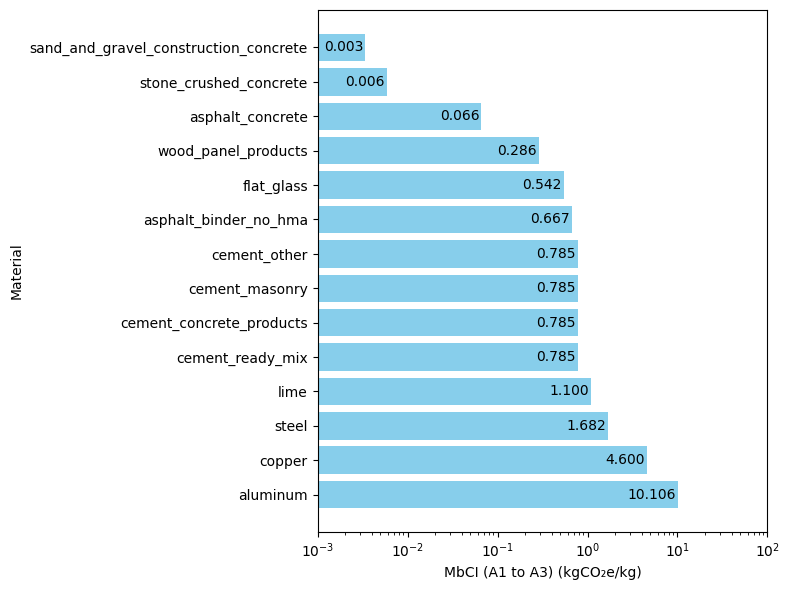

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the dataframe to include only the specified categories
material_ghg = [
    "stone_crushed_concrete",
    "sand_and_gravel_construction_concrete",
    "cement_ready_mix",
    "cement_concrete_products",
    "asphalt_concrete",
    "asphalt_binder_no_hma",
    "cement_masonry",
    "cement_other",
    "steel",
    "aluminum",
    "copper",
    "lime",
    "flat_glass",
    "wood_panel_products"
]

# Filter the dataframe
filtered_material_ghg = ghg_inventory[ghg_inventory['material'].isin(material_ghg)]

# Sort the dataframe by 'mbci_a1_to_a3' in descending order
sorted_material_ghg = filtered_material_ghg.sort_values(by='mbci_a1_to_a3', ascending=False)

# Create the horizontal bar chart
plt.figure(figsize=(8, 6))
bars = plt.barh(sorted_material_ghg['material'], sorted_material_ghg['mbci_a1_to_a3'], color='skyblue')

# Set logarithmic scale for the numeric axis
plt.xscale('log')

# Set x-axis limits (adjust as needed based on your data)
plt.xlim(0.001, 100) #sorted_material_ghg['mbci_a1_to_a3'].max() * 1.1)

# Annotate the bars with their values
for bar, value in zip(bars, sorted_material_ghg['mbci_a1_to_a3']):
    plt.text(
        value * 0.95,  # Position near the end of the bar
        bar.get_y() + bar.get_height() / 2,
        f'{value:.3f}',
        va='center',
        ha='right',  # Align text to the right
        fontsize=10  # Smaller font size
    )

# Customize the plot
plt.xlabel("MbCI (A1 to A3) (kgCO₂e/kg)")
plt.ylabel("Material")
plt.title("")
plt.tight_layout()

# Show the plot
plt.show()


## Material quantity projections

### Approach 1 - based on historic data

#### SARIMA models

In [13]:
historic_data.columns

Index(['year', 'total_us', 'cement_ready_mix', 'cement_concrete_products',
       'cement_masonry', 'cement_other', 'steel', 'pig_iron', 'direct_reduced',
       'iron_and_steel_scrap', 'iron_and_steel_slag', 'iron_ore', 'aluminum',
       'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed',
       'total_forestry', 'lumber', 'plywood_veneer', 'wood_panel_products',
       'asphalt_concrete', 'rap', 'asphalt_binder', 'flat_glass'],
      dtype='object')

In [14]:
import pandas as pd
import openpyxl
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load the Excel file with openpyxl
file_path = './Input Data/Material stock/historic_data_filled.xlsx'
wb = openpyxl.load_workbook(file_path)
sheet = wb.active

# Detect cells with any fill color (highlighted cells)
imputed_data_cells = []
for row in sheet.iter_rows(min_row=2, max_row=sheet.max_row, min_col=2, max_col=sheet.max_column):
    for cell in row:
        if cell.fill.fill_type is not None:  # Check if the cell has any fill
            imputed_data_cells.append((cell.row - 2, cell.column - 1))

# Helper function to group continuous indices
def group_continuous_indices(indices):
    groups = []
    current_group = [indices[0]]
    
    for i in range(1, len(indices)):
        if indices[i] == indices[i - 1] + 1:
            current_group.append(indices[i])
        else:
            groups.append(current_group)
            current_group = [indices[i]]
    
    groups.append(current_group)
    return groups

# Marker size for smaller markers
marker_size = 5  # Adjust this number for desired marker size


##### Modeling

###### Non-stationarity testing
Using the Augmented Dickey-Fuller (ADF) test.

In [15]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load data
file_path = './Input Data/Material stock/historic_data_filled.xlsx'
historic_data_filled = pd.read_excel(file_path)

# Get the list of material columns (excluding 'year')
materials = historic_data_filled.columns[1:]  # Exclude the 'year' column

# Function to check for stationarity using the ADF test
def check_stationarity(series, material_name):
    result = adfuller(series.dropna())  # Drop missing values for test
    p_value = result[1]
    print(f'{material_name} - ADF Statistic: {result[0]:.4f}, p-value: {p_value:.4f}')
    
    if p_value > 0.05:
        print(f'{material_name} is likely **non-stationary** (p-value > 0.05)\n')
    else:
        print(f'{material_name} is likely **stationary** (p-value <= 0.05)\n')

# Iterate over each material and perform the stationarity test
for material in materials:
    material_data = historic_data_filled[material]
    check_stationarity(material_data, material)


total_us - ADF Statistic: -0.5747, p-value: 0.8766
total_us is likely **non-stationary** (p-value > 0.05)

cement_ready_mix - ADF Statistic: -0.9186, p-value: 0.7818
cement_ready_mix is likely **non-stationary** (p-value > 0.05)

cement_concrete_products - ADF Statistic: -0.9186, p-value: 0.7818
cement_concrete_products is likely **non-stationary** (p-value > 0.05)

cement_masonry - ADF Statistic: -0.9186, p-value: 0.7818
cement_masonry is likely **non-stationary** (p-value > 0.05)

cement_other - ADF Statistic: -0.9186, p-value: 0.7818
cement_other is likely **non-stationary** (p-value > 0.05)

steel - ADF Statistic: -1.4908, p-value: 0.5381
steel is likely **non-stationary** (p-value > 0.05)

pig_iron - ADF Statistic: -1.8146, p-value: 0.3733
pig_iron is likely **non-stationary** (p-value > 0.05)

direct_reduced - ADF Statistic: 1.2997, p-value: 0.9966
direct_reduced is likely **non-stationary** (p-value > 0.05)

iron_and_steel_scrap - ADF Statistic: -2.5624, p-value: 0.1010
iron_and

ll the material stock time series tested (total_us, cement types, steel types, aluminum, copper, lime, sand, stone, forestry products, asphalt types, and flat glass) are likely non-stationary, as indicated by p-values greater than 0.05 in the Augmented Dickey-Fuller (ADF) test.

###### Parameter optimization per material
First, let's find the best SARIMA model parameters for each material column. This code finds the best parameters based on the minimum AIC (and report mean absolute error (MAE)) per model. This process uses data from 1900 to 2010 to train the model, and then tests out model accuracy based on data from 2010 to 2020.

In [ ]:
# import pandas as pd
# from pmdarima import auto_arima
# from sklearn.metrics import mean_squared_log_error
# import warnings
# warnings.filterwarnings("ignore")

# # Load data
# file_path = './Input Data/Material stock/historic_data_filled.xlsx'
# historic_data_filled = pd.read_excel(file_path)

# #Specify the materials to be included
# materials_to_include = [
#     'total_us', 'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
#     'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed', 
#     'total_forestry', 'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 
#     'asphalt_binder', 'flat_glass'
# ]


# # Filter the dataframe to only include the specified materials
# historic_data_filled = historic_data_filled[['year'] + materials_to_include]

# # Get the list of material columns (excluding 'year')
# materials = materials_to_include  # Use only the selected materials

# # Define seasonalities to test
# seasonalities = [12, 13, 14, 16, 24, 28]  # Test for these seasonal periods

# # Dictionary to store the best model for each material
# best_sarima_models = {}
# rmse_results = {}  # Dictionary to store RMSE for each material

# # Iterate over each material and try different seasonalities
# for material_column in materials:
#     print(f"Processing material: {material_column}")
    
#     # Select the material data
#     material_data = historic_data_filled[material_column]
    
#     # Use the entire data span (1900–2020) for training and testing
#     train_data = material_data  # Use the entire dataset

#     best_model = None
#     best_rmse = float("inf")  # Initialize best RMSE to a very high value
#     best_seasonal_period = None
    
#     # Iterate over the different seasonalities
#     for seasonal_period in seasonalities:
#         print(f"Testing seasonal period m={seasonal_period}")
        
#         try:
#             # Use auto_arima to find the best SARIMA model for the given seasonality
#             model = auto_arima(
#                 train_data,
#                 start_p=0, start_q=0,
#                 max_p=5, max_q=5,
#                 seasonal=True,
#                 m=seasonal_period,  # Set the current seasonality
#                 d=None,  # Let auto_arima decide the value of d
#                 D=1,  # Differencing for seasonal component
#                 trace=False,  # Disable verbose output for each seasonality
#                 error_action='ignore',  # Ignore errors during fitting
#                 suppress_warnings=True,
#                 stepwise=True,  # Perform stepwise search to reduce computation
#                 n_jobs=-1  # Use all processors for parallelization
#             )

#             # Make predictions for the entire time span (including testing)
#             forecast_steps = len(train_data)  # Predict for the entire period
#             predicted_values = model.predict(n_periods=forecast_steps)
            
#             # Calculate RMSE using the actual data for comparison
#             rmse = mean_squared_error(train_data, predicted_values, squared=False)

#             # Check if the current model has a lower RMSE than the previous best model
#             if rmse < best_rmse:
#                 best_rmse = rmse
#                 best_model = model
#                 best_seasonal_period = seasonal_period
        
#         except Exception as e:
#             print(f"Error with seasonal period m={seasonal_period}: {e}")
#             continue
    
#     # If a valid model was found, store its parameters and RMSE
#     if best_model is not None:
#         best_sarima_models[material_column] = {
#             'order': best_model.order,
#             'seasonal_order': best_model.seasonal_order,
#             'RMSE': best_rmse,  # Store RMSE for the best model
#             'seasonal_period': best_seasonal_period
#         }
#         rmse_results[material_column] = best_rmse  # Store the RMSE
#         print(f'Best SARIMA model for {material_column}: order={best_model.order}, seasonal_order={best_model.seasonal_order}, seasonal_period={best_seasonal_period}, RMSE={best_rmse}')
#     else:
#         print(f"No valid SARIMA model found for {material_column}.")

# # Convert the results to a DataFrame and export it to a CSV file
# results_df = pd.DataFrame(best_sarima_models).T  # Transpose the dictionary for easy viewing
# results_df.to_csv('./Output Data/sarima_best_models_auto_arima_seasonal.csv')

# # Export RMSE results to a separate CSV
# rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE'])
# rmse_df.to_csv('./Output Data/sarima_rmse_results.csv')

# print("Best SARIMA models and RMSE exported to CSV files.")

Let's pick seasonality of 24 for simplicity.

In [16]:
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_log_error, root_mean_squared_error  # Updated import here
import warnings
warnings.filterwarnings("ignore")

# Load data
file_path = './Input Data/Material stock/historic_data_filled.xlsx'
historic_data_filled = pd.read_excel(file_path)

#Specify the materials to be included
materials_to_include = [
    'total_us', 'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed', 
    'total_forestry', 'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 
    'asphalt_binder', 'flat_glass'
]


# Filter the dataframe to only include the specified materials
historic_data_filled = historic_data_filled[['year'] + materials_to_include]

# Get the list of material columns (excluding 'year')
materials = materials_to_include  # Use only the selected materials

# Define seasonalities to test
seasonalities = [24]  # Test for these seasonal periods

# Dictionary to store the best model for each material
best_sarima_models = {}
rmse_results = {}  # Dictionary to store RMSE for each material

# Iterate over each material and try different seasonalities
for material_column in materials:
    print(f"Processing material: {material_column}")
    
    # Select the material data
    material_data = historic_data_filled[material_column]
    
    # Use the entire data span (1900–2020) for training and testing
    train_data = material_data  # Use the entire dataset

    best_model = None
    best_rmse = float("inf")  # Initialize best RMSE to a very high value
    best_seasonal_period = None
    
    # Iterate over the different seasonalities
    for seasonal_period in seasonalities:
        print(f"Testing seasonal period m={seasonal_period}")
        
        try:
            # Use auto_arima to find the best SARIMA model for the given seasonality
            model = auto_arima(
                train_data,
                start_p=0, start_q=0,
                max_p=2, max_q=2,
                seasonal=True,
                m=seasonal_period,  # Set the current seasonality
                d=None,  # Let auto_arima decide the value of d
                D=1,  # Differencing for seasonal component
                trace=False,  # Disable verbose output for each seasonality
                error_action='ignore',  # Ignore errors during fitting
                suppress_warnings=True,
                stepwise=True,  # Perform stepwise search to reduce computation
                n_jobs=-1  # Use all processors for parallelization
            )

            # Make predictions for the entire time span (including testing)
            forecast_steps = len(train_data)  # Predict for the entire period
            predicted_values = model.predict(n_periods=forecast_steps)
            
            # Calculate RMSE using the actual data for comparison
            rmse = root_mean_squared_error(train_data, predicted_values)  # Updated function call

            # Check if the current model has a lower RMSE than the previous best model
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_seasonal_period = seasonal_period
        
        except Exception as e:
            print(f"Error with seasonal period m={seasonal_period}: {e}")
            continue
    
    # If a valid model was found, store its parameters and RMSE
    if best_model is not None:
        best_sarima_models[material_column] = {
            'order': best_model.order,
            'seasonal_order': best_model.seasonal_order,
            'RMSE': best_rmse,  # Store RMSE for the best model
            'seasonal_period': best_seasonal_period
        }
        rmse_results[material_column] = best_rmse  # Store the RMSE
        print(f'Best SARIMA model for {material_column}: order={best_model.order}, seasonal_order={best_model.seasonal_order}, seasonal_period={best_seasonal_period}, RMSE={best_rmse}')
    else:
        print(f"No valid SARIMA model found for {material_column}.")

# Convert the results to a DataFrame and export it to a CSV file
results_df = pd.DataFrame(best_sarima_models).T  # Transpose the dictionary for easy viewing
results_df.to_csv('./OutPut Data/sarima_best_models_auto_arima_seasonal.csv')

# Export RMSE results to a separate CSV
rmse_df = pd.DataFrame.from_dict(rmse_results, orient='index', columns=['RMSE'])
rmse_df.to_csv('./Output Data/sarima_rmse_results.csv')

print("Best SARIMA models and RMSE exported to CSV files.")


Processing material: total_us
Testing seasonal period m=24
Best SARIMA model for total_us: order=(0, 1, 1), seasonal_order=(1, 1, 0, 24), seasonal_period=24, RMSE=2855684488.993674
Processing material: cement_ready_mix
Testing seasonal period m=24
Best SARIMA model for cement_ready_mix: order=(2, 0, 0), seasonal_order=(1, 1, 1, 24), seasonal_period=24, RMSE=70601498.41702925
Processing material: cement_concrete_products
Testing seasonal period m=24
Best SARIMA model for cement_concrete_products: order=(2, 0, 0), seasonal_order=(1, 1, 1, 24), seasonal_period=24, RMSE=12722875.309695616
Processing material: cement_masonry
Testing seasonal period m=24
Best SARIMA model for cement_masonry: order=(2, 0, 0), seasonal_order=(1, 1, 1, 24), seasonal_period=24, RMSE=4198145.643590264
Processing material: cement_other
Testing seasonal period m=24
Best SARIMA model for cement_other: order=(2, 0, 0), seasonal_order=(1, 1, 1, 24), seasonal_period=24, RMSE=18898992.604217812
Processing material: stee

OSError: Cannot save file into a non-existent directory: 'Outlut Data'

###### SARIMA model implementation
Now, use the parameters defined in the previous step to implement the model.

In [102]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the best SARIMA models from the previous results
best_sarima_models = pd.read_csv('./Output Data/sarima_best_models_auto_arima_seasonal.csv', index_col=0)

# Load the historic data again to ensure it's in the environment
historic_data_filled = pd.read_excel('./Input Data/Material stock/historic_data_filled.xlsx')

#Specify the materials to be included
materials_to_include = [
    'total_us', 'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed', 
    'total_forestry', 'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 
    'asphalt_binder', 'flat_glass'
]

# Filter the dataframe to only include the specified materials
historic_data_filled = historic_data_filled[['year'] + materials_to_include]

# Extract the year column and material columns (excluding 'total_us')
years = historic_data_filled['year']
materials = materials_to_include  # Use only the specified materials

# Create an empty dataframe for storing projections
projection_years = list(range(years.max() + 1, 2051))
projection_df = pd.DataFrame({'year': projection_years})

# Placeholder for projected data
projected_data = {}

# Function to fit SARIMA model and make predictions using custom parameters
def sarima_forecast_with_params(material_data, forecast_steps, order, seasonal_order):
    model = SARIMAX(material_data, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    
    forecast = result.get_forecast(steps=forecast_steps)
    pred_values = forecast.predicted_mean
    
    return pred_values

# Iterate over each material column and apply the best SARIMA model
for material in materials:
    print(f"Processing material: {material}")
    
    # Select the material data
    material_data = historic_data_filled[material]
    
    # Retrieve the best SARIMA model parameters for the current material
    if material in best_sarima_models.index:
        # Extract the best SARIMA parameters from the DataFrame
        order = eval(best_sarima_models.loc[material, 'order'])
        seasonal_order = eval(best_sarima_models.loc[material, 'seasonal_order'])
    else:
        # Use default parameters if no custom parameters are found
        print(f"No custom parameters found for {material}, using default SARIMA parameters.")
        order = (1, 1, 1)
        seasonal_order = (1, 1, 1, 12)
    
    # Perform SARIMA forecasting
    forecast_steps = len(projection_years)
    pred_values = sarima_forecast_with_params(material_data, forecast_steps, order, seasonal_order)
    
    # Store the forecasted data in the projected_data dictionary
    projected_data[material] = pred_values

# Convert projected_data dictionary to a DataFrame for export
for material in projected_data:
    projection_df[material] = projected_data[material].values

# Save the projections to a CSV file
projection_df.to_csv('./Output Data/material_projections.csv', index=False)

print("Projections for all materials saved to 'material_projections.csv'.")


Processing material: total_us
Processing material: cement_ready_mix
Processing material: cement_concrete_products
Processing material: cement_masonry
Processing material: cement_other
Processing material: steel
Processing material: aluminum
Processing material: copper
Processing material: lime
Processing material: sand_and_gravel_construction
Processing material: stone_crushed
Processing material: total_forestry
Processing material: lumber
Processing material: plywood_veneer
Processing material: wood_panel_products
Processing material: asphalt_concrete
Processing material: asphalt_binder
Processing material: flat_glass
Projections for all materials saved to 'material_projections.csv'.


###### Prediction vs. Estimates

Processing material: total_us
Processing material: cement_ready_mix
Processing material: cement_concrete_products
Processing material: cement_masonry
Processing material: cement_other
Processing material: steel
Processing material: aluminum
Processing material: copper
Processing material: lime
Processing material: sand_and_gravel_construction
Processing material: stone_crushed
Processing material: total_forestry
Processing material: lumber
Processing material: plywood_veneer
Processing material: wood_panel_products
Processing material: asphalt_concrete
Processing material: asphalt_binder
Processing material: flat_glass


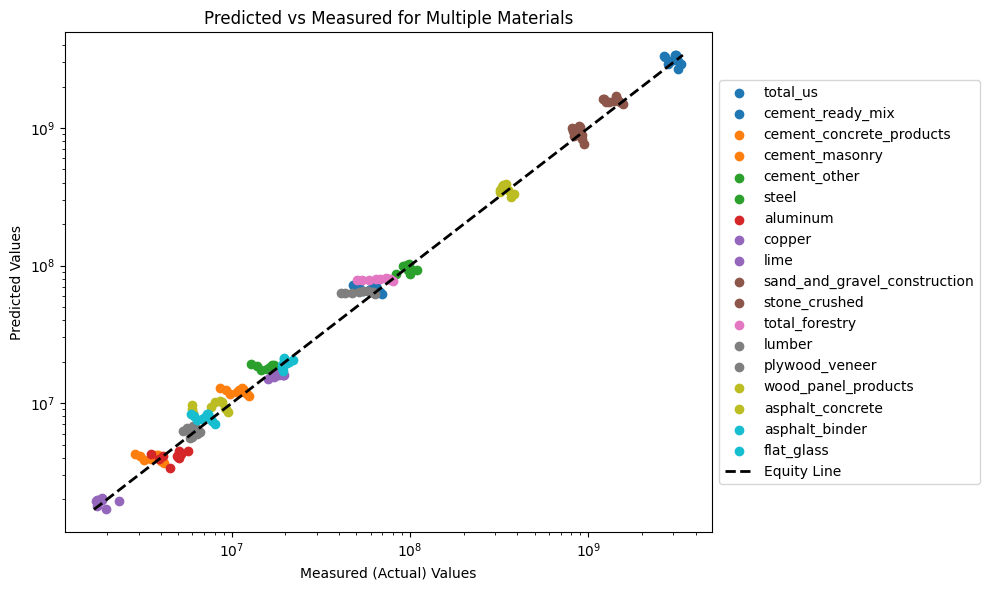

In [103]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the historical data and the projections
file_path = './Input Data/Material stock/historic_data_filled.xlsx'
historic_data_filled = pd.read_excel(file_path)

# Load the forecasted projections from the CSV file generated earlier
projections_df = pd.read_csv('./Output Data/material_projections.csv')

# Define colors for plotting different materials
colors = plt.cm.get_cmap('tab10', len(materials_to_include))

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Initialize lists to store all measured and predicted values for min/max calculation
all_measured = []
all_predicted = []

# Iterate over each material column and plot the comparison between actual and predicted values
for idx, material in enumerate(materials_to_include):
    if material not in historic_data_filled.columns or material not in projections_df.columns:
        continue

    print(f"Processing material: {material}")
    
    # Select the material data
    material_data = historic_data_filled[material]
    
    # Split the data into train (up to 2010) and test (after 2010)
    test_data = material_data[historic_data_filled['year'] > 2010]
    
    # Get the predicted values from the projections
    predicted_values = projections_df[material].iloc[:len(test_data)].values
    
    # Scatter plot: Measured (x) vs Predicted (y) for each material
    plt.scatter(test_data, predicted_values, label=f'{material}', color=colors(idx), marker='o')
    
    # Append the measured and predicted values to the lists for min/max calculation
    all_measured.extend(test_data)
    all_predicted.extend(predicted_values)

# Calculate min and max for both measured and predicted values
min_val = min(min(all_measured), min(all_predicted))
max_val = max(max(all_measured), max(all_predicted))

# Plot the equity line (perfect prediction line)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Equity Line')

# Set axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Add title and labels
plt.title('Predicted vs Measured for Multiple Materials')
plt.xlabel('Measured (Actual) Values')
plt.ylabel('Predicted Values')

# Place legend outside the plot area on the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()


##### Model visualizations

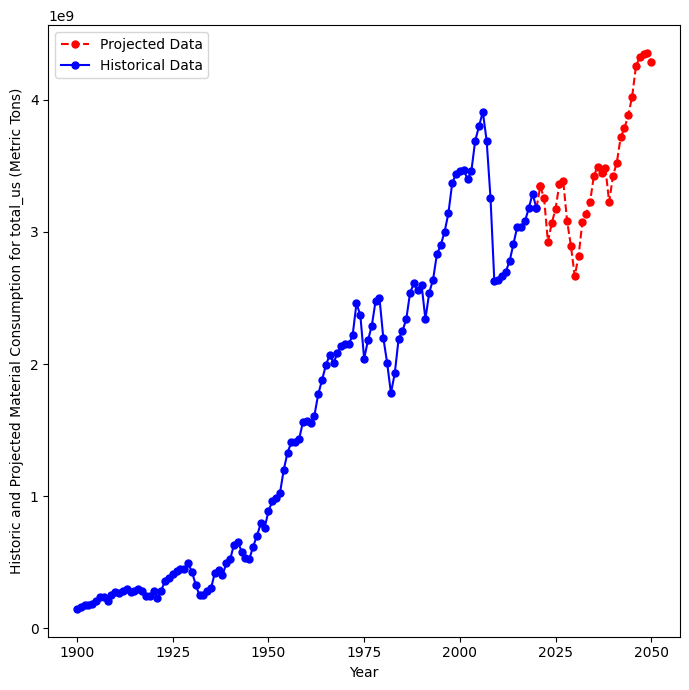

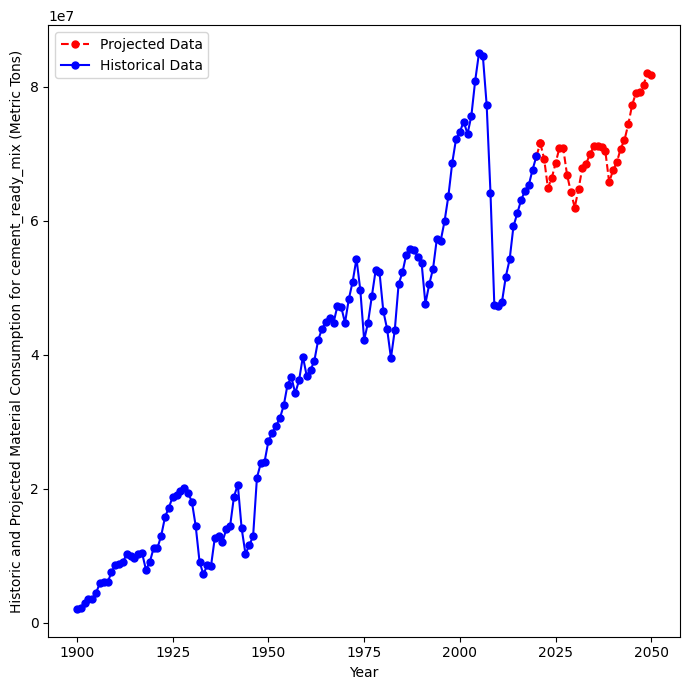

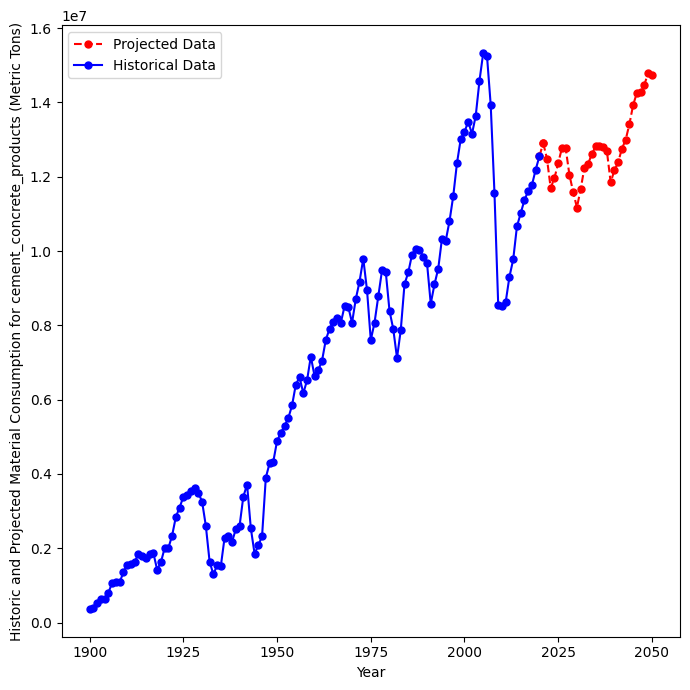

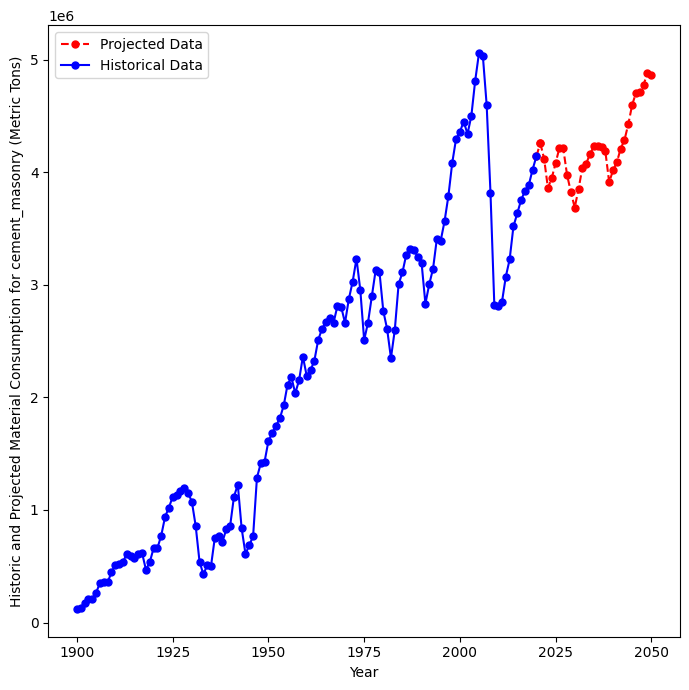

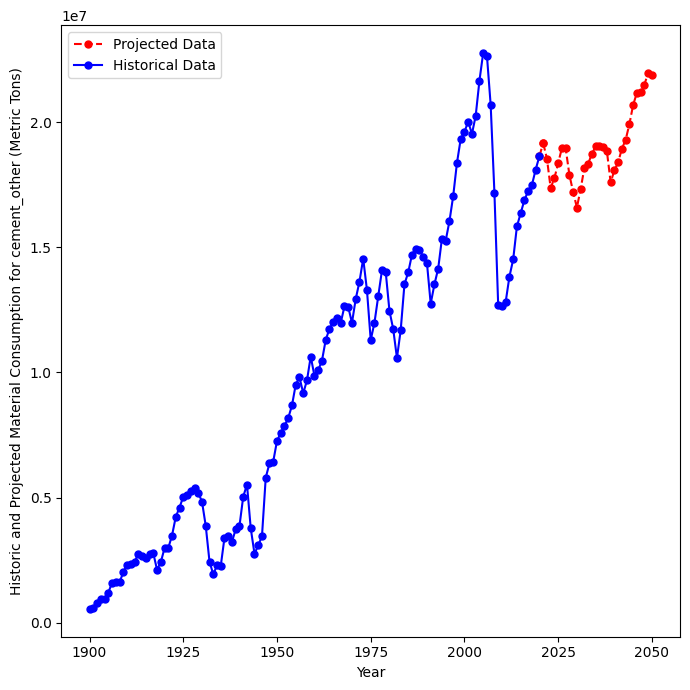

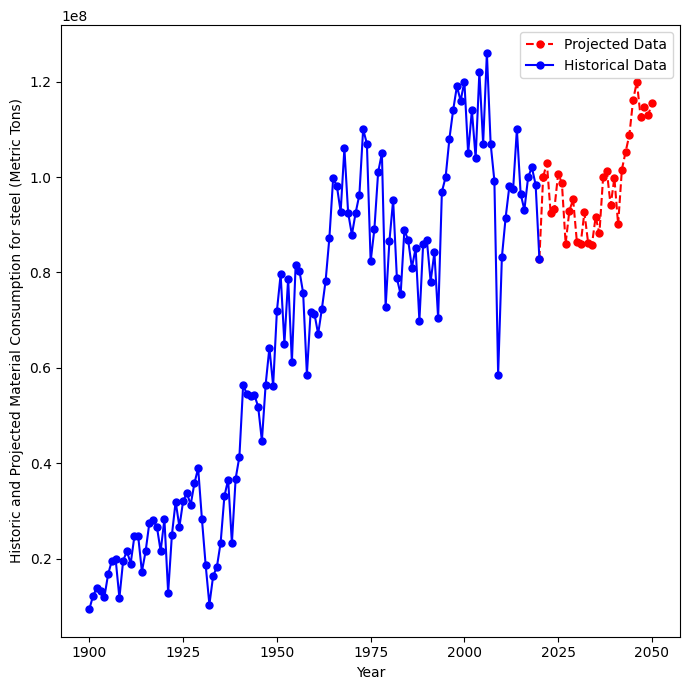

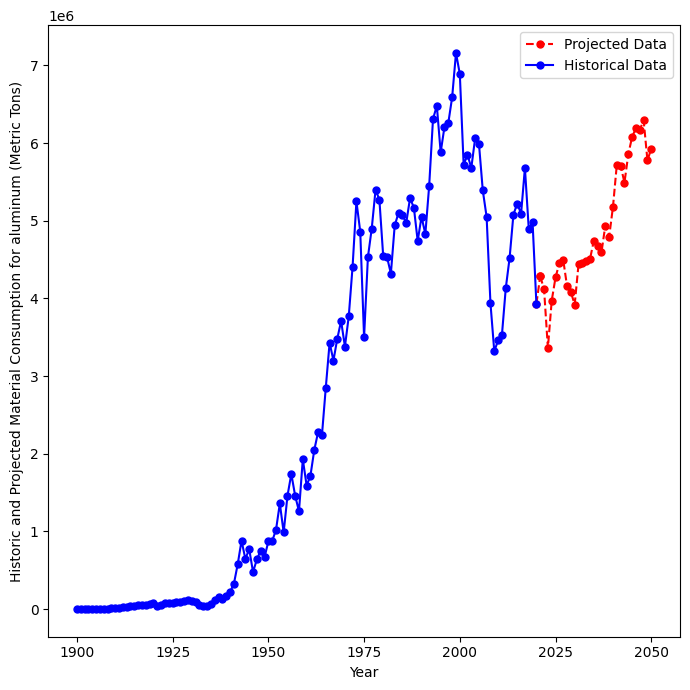

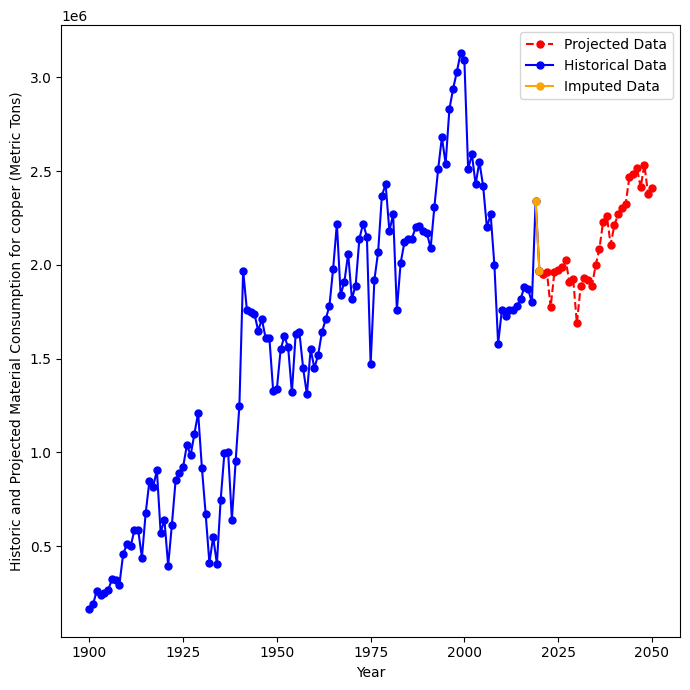

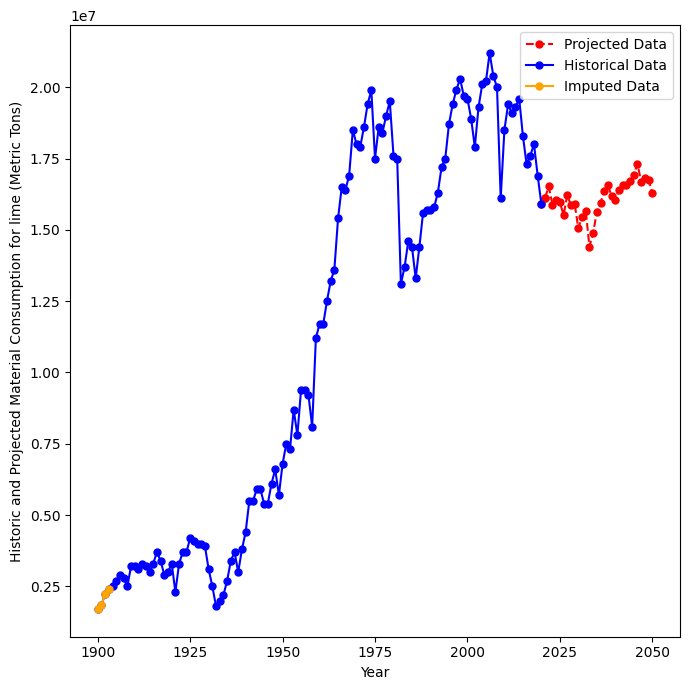

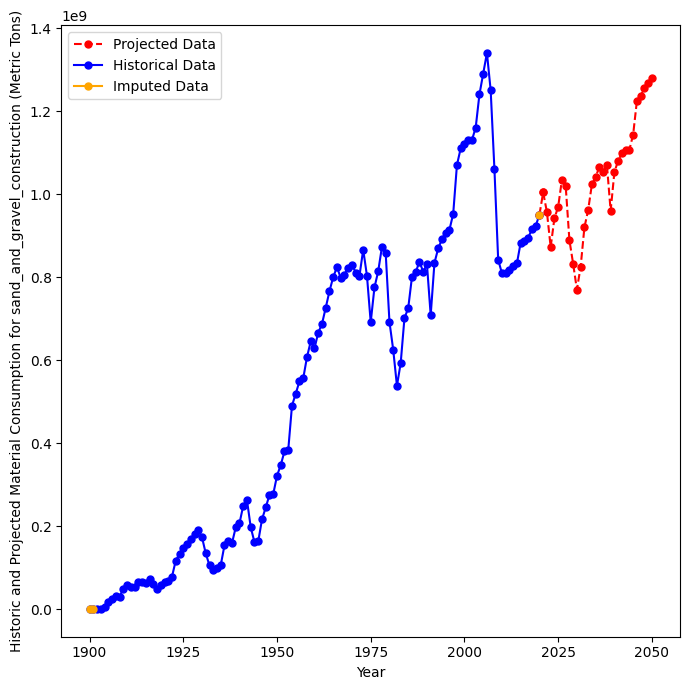

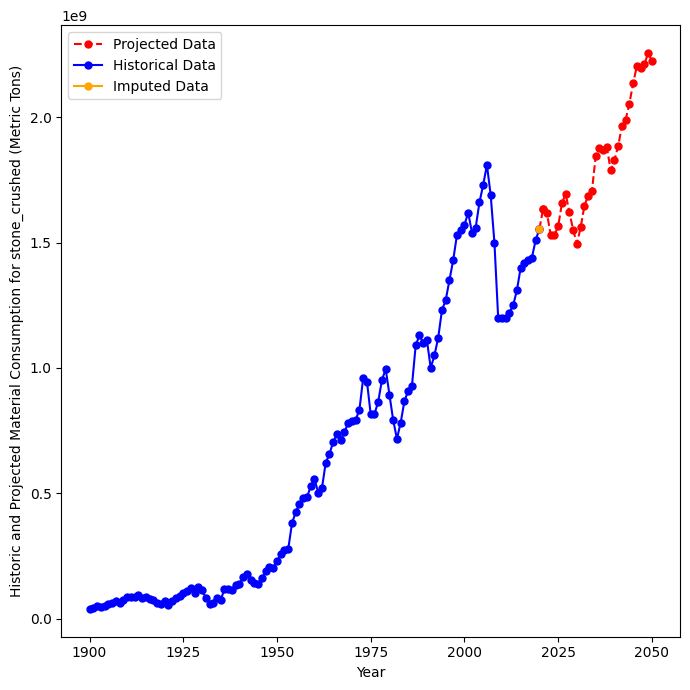

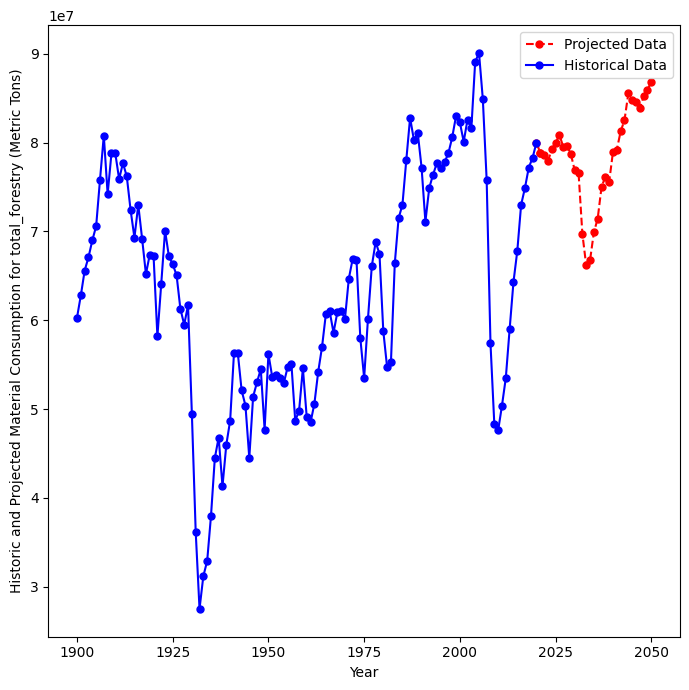

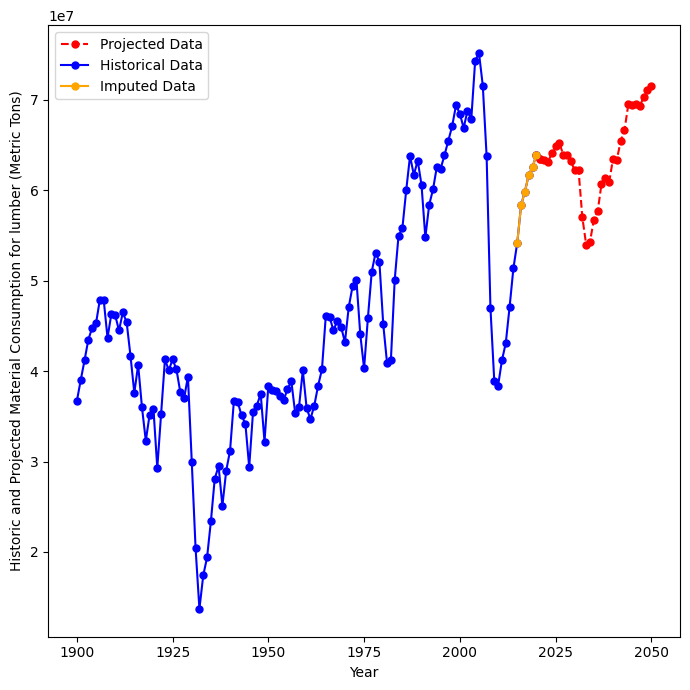

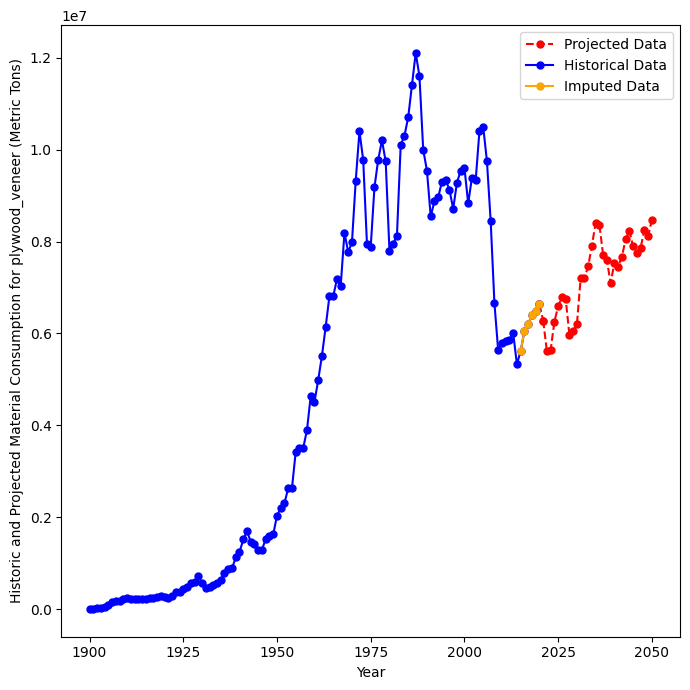

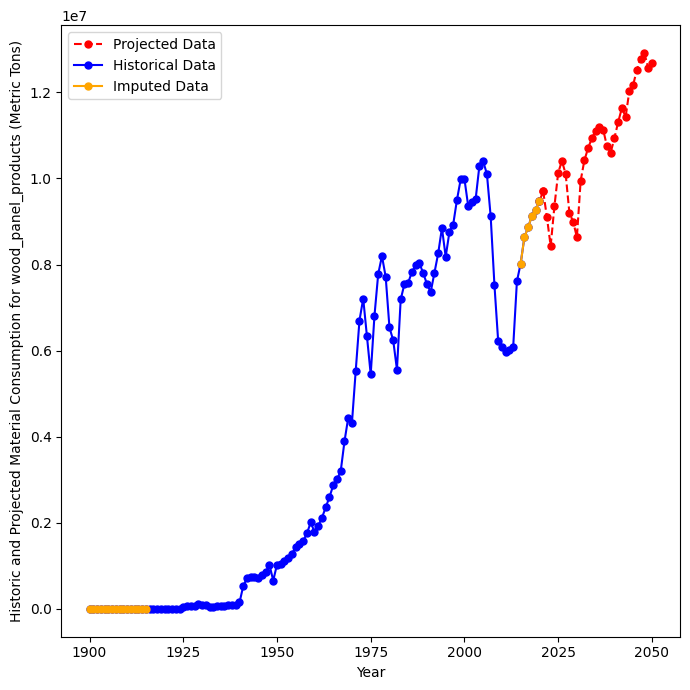

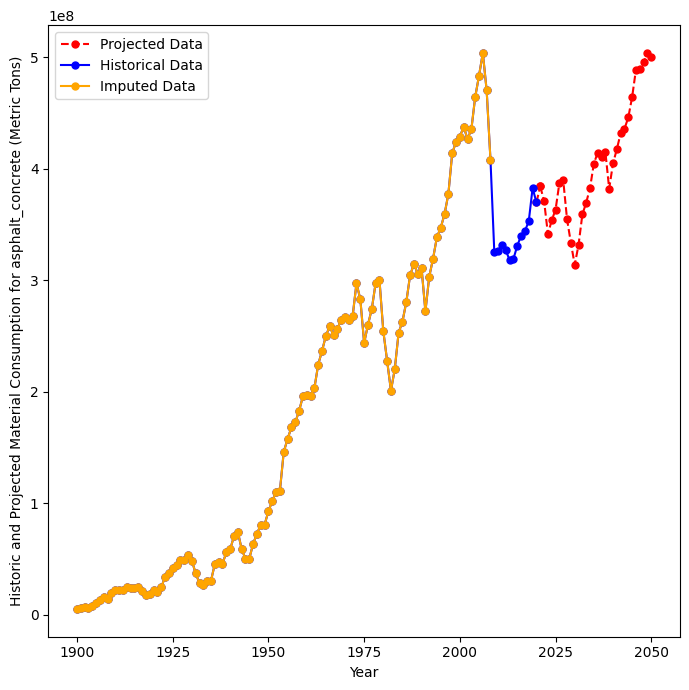

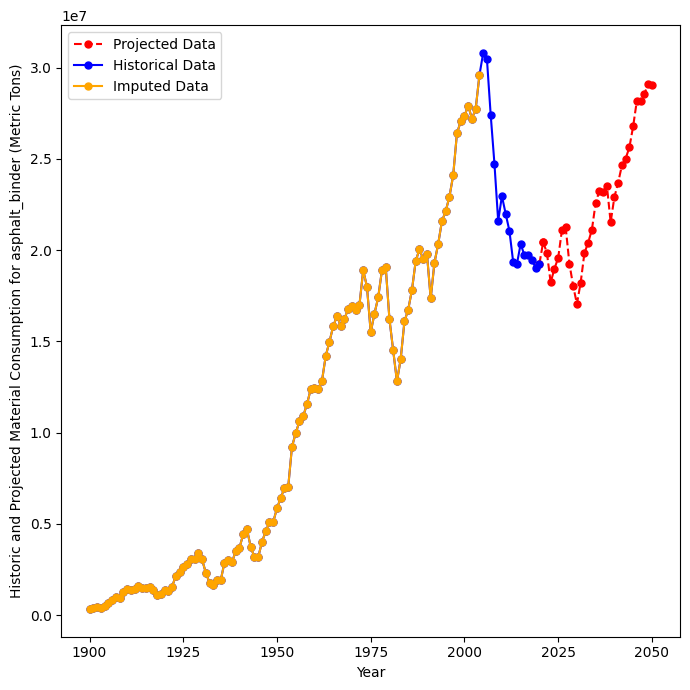

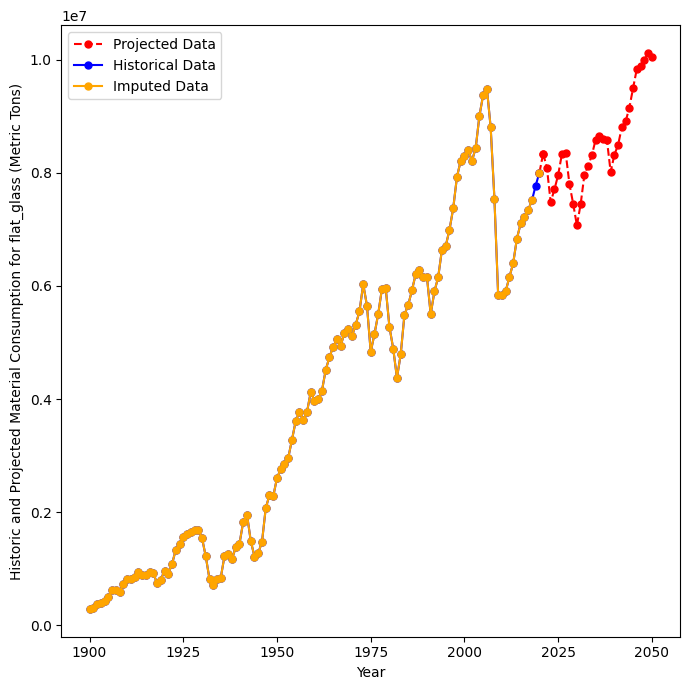

In [104]:
import matplotlib.pyplot as plt

# Marker size for smaller markers
marker_size = 5  # Adjust this number for desired marker size

# Set the desired x-axis ticks (25-year intervals)
x_ticks = list(range(int(years.min()), 2051, 25))  # Adjust for 25-year intervals, including 2050

# Iterate over each material column and plot the data
for material in materials:
    material_data = historic_data_filled[material]
    
    # Retrieve the forecasted data
    pred_values = projections_df[material]
    
    # Combine historical and projection data for continuity
    full_years = pd.concat([years, pd.Series(projection_years)], ignore_index=True)
    full_data = pd.concat([material_data, pd.Series(pred_values)], ignore_index=True)

    # Identify highlighted (imputed) data points for the current material
    imputed_indices = [index for index, col in imputed_data_cells if col == historic_data_filled.columns.get_loc(material)]
    
    # Group imputed data into continuous segments
    imputed_groups = group_continuous_indices(imputed_indices) if imputed_indices else []
    
    # Create the plot and set the gridlines behind the plot elements
    plt.figure(figsize=(7, 7))
    
    # Plot the projections first (zorder=2, below the historical data)
    plt.plot(projection_years, pred_values, label='Projected Data', color='red', linestyle='--', marker='o', markersize=marker_size, zorder=3)
    
    # Connect the projections with the last point of historical data (2020)
    last_year = years.max()
    plt.plot([last_year, projection_years[0]], [material_data.iloc[-1], pred_values.iloc[0]], color='red', linestyle='--', marker='o', markersize=marker_size, zorder=3)

    # Plot the historical data (zorder=4, drawn on top)
    plt.plot(years, material_data, label='Historical Data', color='blue', linestyle='-', marker='o', markersize=marker_size, zorder=4)

    # Plot each imputed group as separate segments (zorder=4, drawn on top) with a single label for the first group
    for i, group in enumerate(imputed_groups):
        label = 'Imputed Data' if i == 0 else '_nolegend_'  # Only label the first group
        plt.plot(years.iloc[group], material_data.iloc[group], color='orange', linestyle='-', marker='o', markersize=marker_size, label=label, zorder=4)

    # Set x-axis ticks to 25-year intervals
    plt.xticks(x_ticks)
    
    # Set gridlines with default zorder
    # plt.grid(True, zorder=1)

    plt.title("")
    plt.xlabel("Year")
    plt.ylabel(f"Historic and Projected Material Consumption for {material} (Metric Tons)")
    plt.legend()
    plt.tight_layout()
    
    # Display the plot
    plt.show()


###### Final visualizations

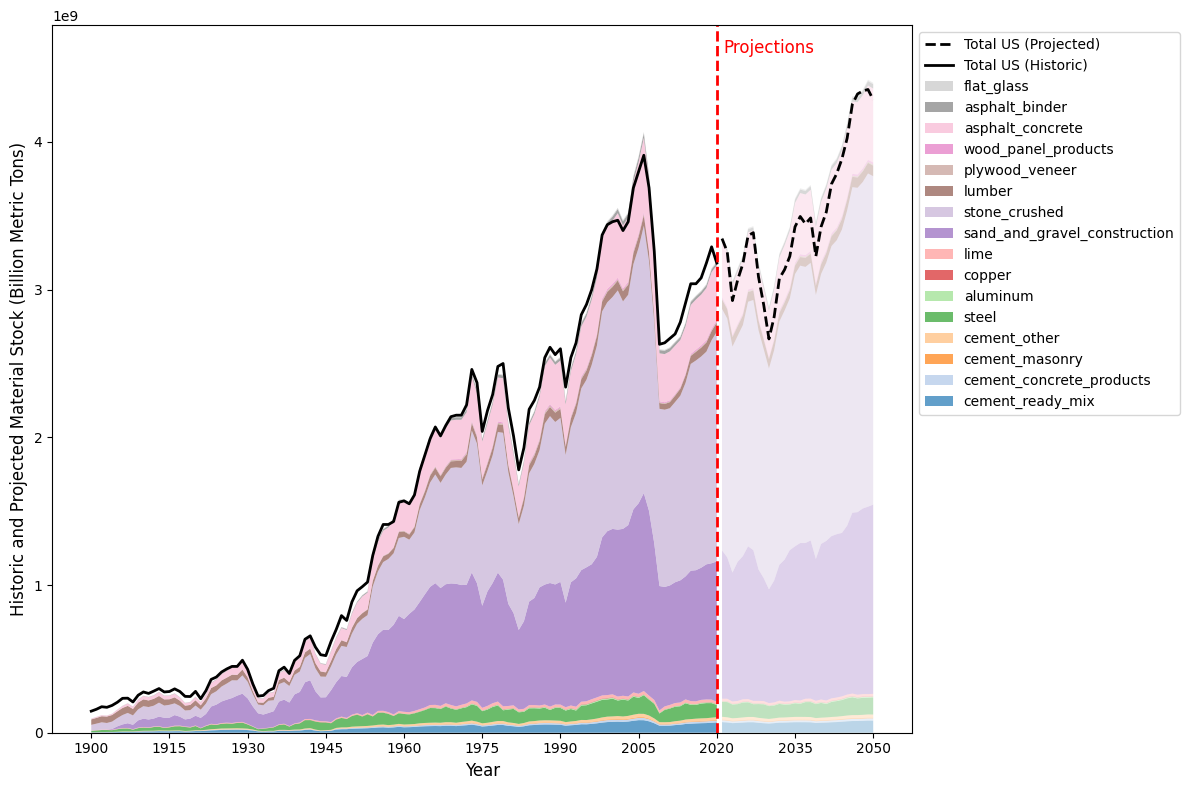

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

projection_df = pd.read_csv('./Output Data/material_projections.csv')

# List of columns for the stacked area plot
columns_to_plot = [
    'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed',
    'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 'asphalt_binder', 'flat_glass'
]

# Check if 'year' is already the index, if not, set it as the index
if 'year' in historic_data_filled.columns:
    historic_data_filled = historic_data_filled.set_index('year')

if 'year' in projection_df.columns:
    projection_df = projection_df.set_index('year')

# Combine historical and projected data for the selected columns
stacked_area_data_historic = historic_data_filled[columns_to_plot]
stacked_area_data_projected = projection_df[columns_to_plot]

# Combine historical and projected data for 'total_us'
total_us_data_historic = historic_data_filled['total_us']
total_us_data_projected = projection_df['total_us']

# Calculate the max value of 'total_us' for setting the plot limits and annotations
max_total_us = max(total_us_data_historic.max(), total_us_data_projected.max())

# Create a colormap with the same colors for both historic and projected data
colors = plt.get_cmap('tab20').colors[:len(columns_to_plot)]

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plot the stacked area chart for the historic data (more opaque)
plt.stackplot(stacked_area_data_historic.index, stacked_area_data_historic.T, labels=columns_to_plot, colors=colors, alpha=0.7)

# Overlay the stacked area chart for the projected data (same colors, less opaque)
plt.stackplot(stacked_area_data_projected.index, stacked_area_data_projected.T, colors=colors, alpha=0.3)

# Plot the 'total_us' line chart for historic and projected data
plt.plot(total_us_data_historic.index, total_us_data_historic.values, label='Total US (Historic)', color='black', linewidth=2)
plt.plot(total_us_data_projected.index, total_us_data_projected.values, label='Total US (Projected)', color='black', linewidth=2, linestyle='--')

# Add a vertical line at the year 2020 to indicate when projections start
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation at the top of the vertical line
plt.annotate('Projections', xy=(2025, max_total_us * 1.05), xytext=(2030, max_total_us * 1.05),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Adjust the y-axis to accommodate both the stacked area and the 'total_us' line chart
plt.ylim(0, max_total_us * 1.1)  # Set y-axis limit to slightly above the max value of 'total_us'

# Customize the x-axis to show the correct year values
plt.xticks(range(1900, 2051, 15))  # Set x-axis ticks from 1900 to 2050 in 15-year intervals

# Reverse the order of the legend entries
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove the gridlines
plt.grid(False)

# Customize the plot
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Historic and Projected Material Stock (Billion Metric Tons)', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


##### Construction materials share

Historic:

In [106]:
import pandas as pd

# Load the projection and construction share data
construction_historic_df = historic_data_filled.reset_index()  # Reset index to ensure 'year' is a column

# List of columns to modify
columns_to_plot = [
    'total_us', 'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed',
    'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 'asphalt_binder', 'flat_glass'
]

# Fill missing values in construction_share with the median for each column
construction_share_filled = construction_share.set_index('year').copy()  # Set 'year' as the index
for column in columns_to_plot:
    if column in construction_share.columns:
        median_value = construction_share[column].median()
        # Fill missing values with the median
        construction_share_filled[column].fillna(median_value, inplace=True)
    else:
        print(f"Warning: {column} not found in construction_share.")

# Multiply each year's data in construction_historic_df by the corresponding values in construction_share_filled
for column in columns_to_plot:
    if column in construction_historic_df.columns and column in construction_share_filled.columns:
        # Reindex to align with construction_historic_df's year values
        construction_historic_df[column] = (
            construction_historic_df[column] * construction_share_filled[column].reindex(construction_historic_df['year']).values
        )

# Ensure 'year' is included in the final DataFrame and keep only valid columns
filtered_construction_quantity_df = construction_historic_df[['year'] + columns_to_plot]

# Save the modified DataFrame to a new CSV file
output_path = './Output Data/construction_material_historic.csv'
filtered_construction_quantity_df.to_csv(output_path, index=False)

print(f"New file saved at: {output_path}")


New file saved at: ./Output Data/construction_material_historic.csv


In [107]:
filtered_construction_quantity_df.tail()

,year,total_us,cement_ready_mix,cement_concrete_products,cement_masonry,cement_other,steel,aluminum,copper,lime,sand_and_gravel_construction,stone_crushed,lumber,plywood_veneer,wood_panel_products,asphalt_concrete,asphalt_binder,flat_glass
116,2016,2.210000e+09,63123822.41,11375346.55,3753503.448,0.0,32585000.0,9.738730e+05,770800.000000,1384000.0,8.880000e+08,1.420000e+09,NaN,6.051166e+06,8.639658e+06,340103656.5,19712305.34,7.218929e+06
117,2017,2.200000e+09,64457284.14,11615645.52,3832794.483,0.0,35000000.0,1.086758e+06,766700.000000,1408000.0,8.950000e+08,1.430000e+09,NaN,6.208663e+06,8.864526e+06,344185989.0,19727480.07,7.342807e+06
118,2018,2.280000e+09,65346258.62,11775844.83,3885655.172,0.0,35700000.0,9.375202e+05,738000.000000,1440000.0,9.150000e+08,1.440000e+09,NaN,6.399316e+06,9.136734e+06,353167120.5,19457138.94,7.512048e+06
119,2019,2.400000e+09,67668206.90,12194275.86,4023724.138,0.0,34440000.0,9.528266e+05,958782.510121,1352000.0,9.230000e+08,1.510000e+09,NaN,6.490498e+06,9.266921e+06,382741351.5,19028452.79,7.775435e+06
120,2020,2.370000e+09,69658448.28,12552931.03,4142068.966,0.0,29015000.0,7.519294e+05,807754.777328,1272000.0,9.501471e+08,1.554412e+09,NaN,6.631415e+06,9.468118e+06,369950043.0,19252939.84,8.004124e+06


Projections:

In [108]:
import pandas as pd

# Load the projection and construction share data
construction_projection_df = pd.read_csv('./Output Data/material_projections.csv')

# List of columns to modify
columns_to_plot = [
    'total_us', 'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed',
    'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 'asphalt_binder', 'flat_glass'
]

# Identify the last available value for each specified column in construction_share, skipping columns with all NaNs
last_available_values = {}
for column in columns_to_plot:
    non_na_values = construction_share[column].dropna()
    if not non_na_values.empty:
        last_available_values[column] = non_na_values.iloc[-1]  # Use the last non-NaN value

# Filter out columns where there is no available value (i.e., all values are NaN)
valid_columns = list(last_available_values.keys())
filtered_last_values = pd.Series(last_available_values)

# Multiply each valid column in construction_projection_df by the corresponding last available value
for column in valid_columns:
    construction_projection_df[column] = construction_projection_df[column] * filtered_last_values[column]

# Keep only the 'year' column and the valid columns in the final DataFrame
filtered_construction_projection_df = construction_projection_df[['year'] + valid_columns]

# Save the modified DataFrame to a new CSV file
output_path = './Output Data/construction_material_projections.csv'
filtered_construction_projection_df.to_csv(output_path, index=False)

print(f"New file saved at: {output_path}")


New file saved at: ./Output Data/construction_material_projections.csv


In [109]:
filtered_construction_projection_df.head()

,year,total_us,cement_ready_mix,cement_concrete_products,cement_masonry,cement_other,steel,aluminum,copper,lime,sand_and_gravel_construction,stone_crushed,plywood_veneer,wood_panel_products,asphalt_concrete,asphalt_binder,flat_glass
0,2021,2.493561e+09,7.162206e+07,1.290679e+07,4.258834e+06,0.0,3.500214e+07,686038.948470,936654.667834,2.095811e+06,1.003846e+09,1.635242e+09,6.282112e+06,9.705235e+06,3.842294e+08,2.044206e+07,8.339693e+06
1,2022,2.426590e+09,6.931663e+07,1.249136e+07,4.121750e+06,0.0,3.602601e+07,658848.048417,942265.869214,2.147473e+06,9.568601e+08,1.617753e+09,5.610460e+06,9.099550e+06,3.711408e+08,1.985152e+07,8.090086e+06
2,2023,2.180777e+09,6.491495e+07,1.169818e+07,3.860017e+06,0.0,3.235764e+07,538009.470706,851696.653771,2.064219e+06,8.723324e+08,1.530926e+09,5.648614e+06,8.431114e+06,3.414871e+08,1.822718e+07,7.481383e+06
3,2024,2.285077e+09,6.638973e+07,1.196395e+07,3.947714e+06,0.0,3.265383e+07,635441.080176,940860.267547,2.083872e+06,9.414387e+08,1.531095e+09,6.257129e+06,9.352183e+06,3.538608e+08,1.898088e+07,7.706316e+06
4,2025,2.367026e+09,6.861678e+07,1.236528e+07,4.080143e+06,0.0,3.524868e+07,683643.843156,946469.217209,2.075118e+06,9.691995e+08,1.564471e+09,6.592278e+06,1.012871e+07,3.634509e+08,1.957093e+07,7.962700e+06


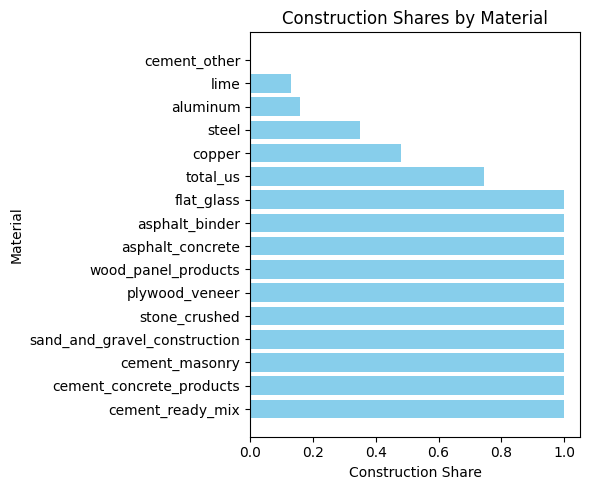

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract construction shares for plotting
construction_share_values = pd.Series(last_available_values).sort_values(ascending=False)

# Create a horizontal bar chart
plt.figure(figsize=(6, 5))
bars = plt.barh(construction_share_values.index, construction_share_values.values, color='skyblue')

# # Annotate the bars with their values
# for bar, value in zip(bars, construction_share_values.values):
#     plt.text(
#         value * 0.95,  # Position near the end of the bar
#         bar.get_y() + bar.get_height() / 2,
#         f'{value:.4f}',
#         va='center',
#         ha='right',
#         fontsize=8
#     )

# Customize the plot
plt.xlabel("Construction Share")
plt.ylabel("Material")
plt.title("Construction Shares by Material")
plt.tight_layout()

# Show the plot
plt.show()


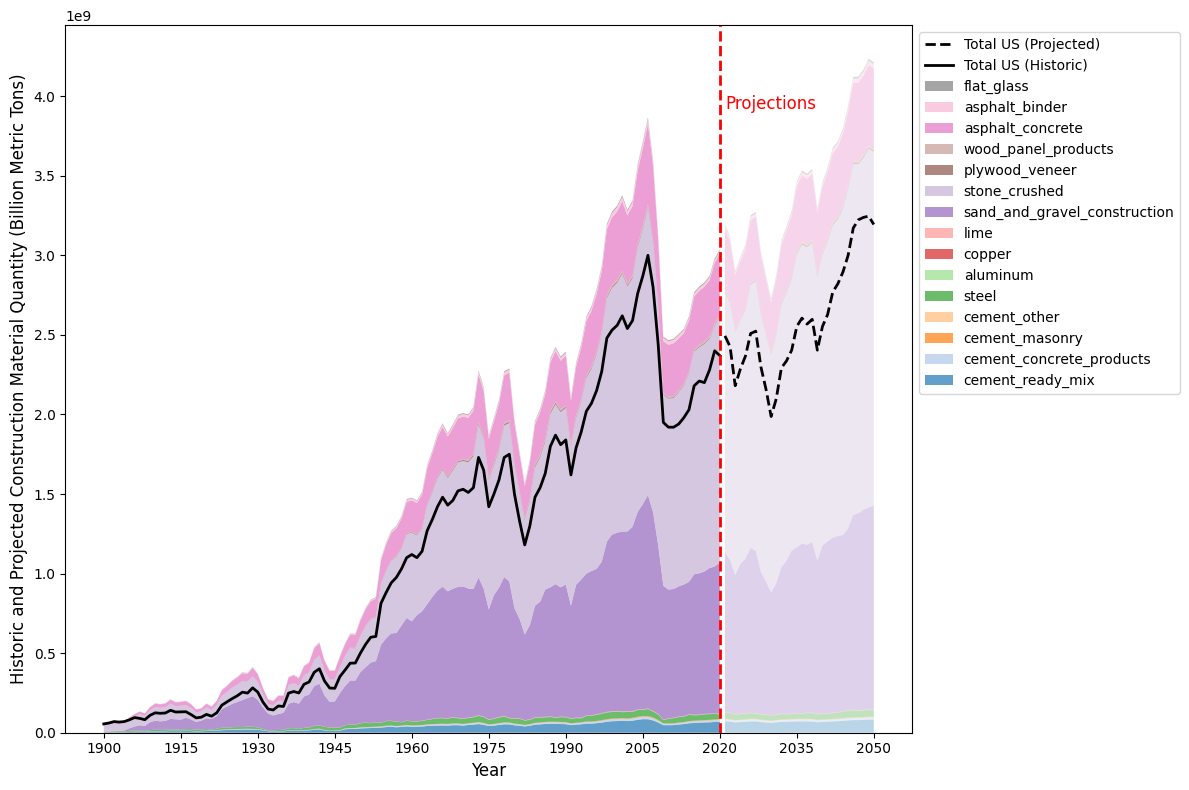

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns for the stacked area plot
columns_to_plot = [
    'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed',
    'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 'asphalt_binder', 'flat_glass'
]

# Ensure 'year' is set as the index for both historical and projection data
if 'year' in filtered_construction_quantity_df.columns:
    filtered_construction_quantity_df = filtered_construction_quantity_df.set_index('year')

if 'year' in filtered_construction_projection_df.columns:
    filtered_construction_projection_df = filtered_construction_projection_df.set_index('year')

# Filter columns that exist in both DataFrames
valid_columns = [col for col in columns_to_plot if col in filtered_construction_quantity_df.columns and col in filtered_construction_projection_df.columns]

# Extract data for the valid columns only
stacked_area_data_historic = filtered_construction_quantity_df[valid_columns]
stacked_area_data_projected = filtered_construction_projection_df[valid_columns]

# Extract 'total_us' data for both historic and projected data if available
if 'total_us' in filtered_construction_quantity_df.columns and 'total_us' in filtered_construction_projection_df.columns:
    total_us_data_historic = filtered_construction_quantity_df['total_us']
    total_us_data_projected = filtered_construction_projection_df['total_us']
    max_total_us = max(total_us_data_historic.max(), total_us_data_projected.max())
else:
    print("Warning: 'total_us' column not found in one of the datasets.")
    max_total_us = max(stacked_area_data_historic.sum(axis=1).max(), stacked_area_data_projected.sum(axis=1).max())

# Set up colors and plot
colors = plt.get_cmap('tab20').colors[:len(valid_columns)]

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plot the stacked area chart for historic data (more opaque)
plt.stackplot(stacked_area_data_historic.index, stacked_area_data_historic.T, labels=valid_columns, colors=colors, alpha=0.7)

# Overlay the stacked area chart for projected data (less opaque)
plt.stackplot(stacked_area_data_projected.index, stacked_area_data_projected.T, colors=colors, alpha=0.3)

# Plot the 'total_us' line for historic and projected data if it exists
if 'total_us' in filtered_construction_quantity_df.columns and 'total_us' in filtered_construction_projection_df.columns:
    plt.plot(total_us_data_historic.index, total_us_data_historic.values, label='Total US (Historic)', color='black', linewidth=2)
    plt.plot(total_us_data_projected.index, total_us_data_projected.values, label='Total US (Projected)', color='black', linewidth=2, linestyle='--')

# Add a vertical line at the year 2020
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation above the vertical line
plt.annotate('Projections', xy=(2025, max_total_us * 1.2), xytext=(2030, max_total_us * 1.2),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Customize x-axis
plt.xticks(range(1900, 2051, 15))

# Reverse the legend entries order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove gridlines
plt.grid(False)

# Customize the plot
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Historic and Projected Construction Material Quantity (Billion Metric Tons)', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


###### Construction material recategorization

Assumptions:

* Concrete:
    - The rest of crushed stone not in hma is in concrete
    - average cement mass % = 12%
    - average water-to-cement ratio = 0.45
    - average aggregate content = 81%


* Asphalt:
    - average asphalt binder content = 3.5% (if needed)
    - average rap content in 2020 = 20% (if needed)


 * `sand_and_gravel_construction`:
    - "_concrete" equals 27% of sand_and_gravel_construction
    - "_asphalt" equals 9% of sand_and_gravel_construction
    - "_road_base_fill" equals 23% of sand_and_gravel_construction
    - "_other_construction" equals 41% of sand_and_gravel_construction

* `stone_crushed`:
    - "_no_construction" = 44%
    - "_aggregate" = 56%

* Steel:
    - Percent of total steel used in construction = 35%

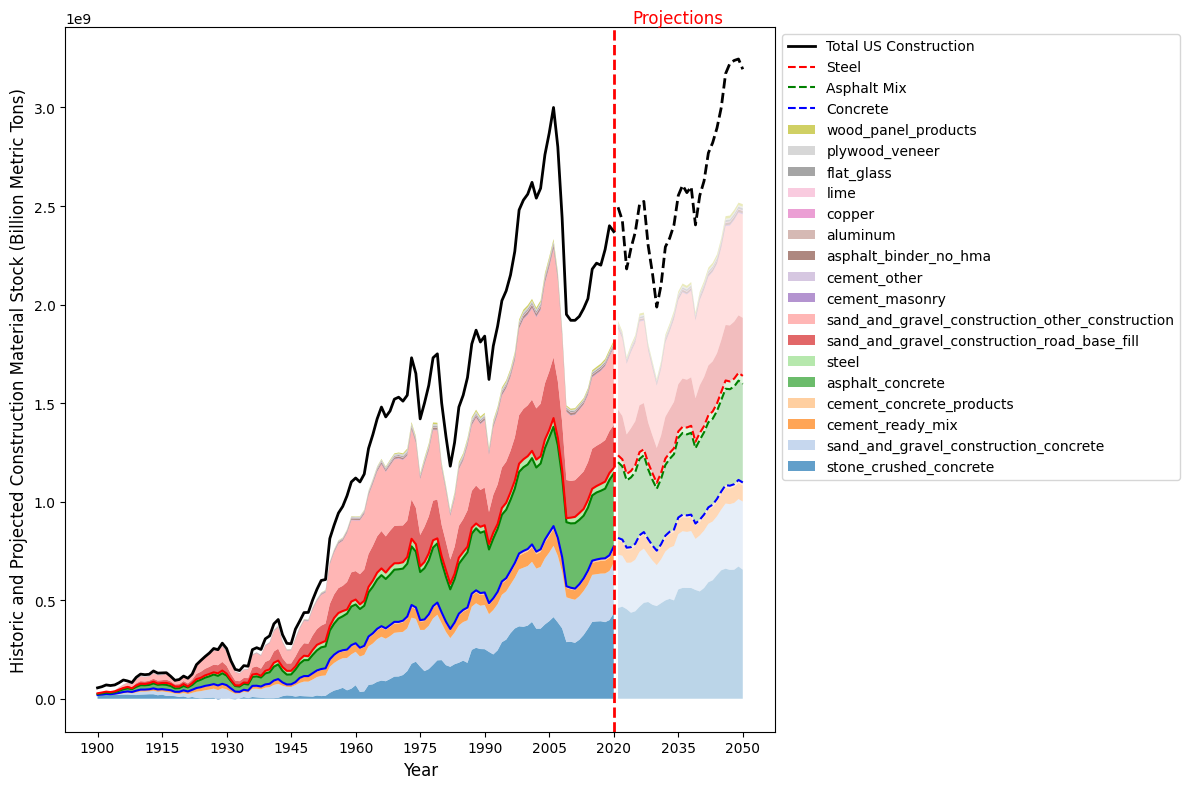

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

# Breakdown of sand_and_gravel_construction
filtered_construction_quantity_df['sand_and_gravel_construction_concrete'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.27
filtered_construction_quantity_df['sand_and_gravel_construction_asphalt'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.09
filtered_construction_quantity_df['sand_and_gravel_construction_road_base_fill'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.23
filtered_construction_quantity_df['sand_and_gravel_construction_other_construction'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.41

# Breakdown of stone_crushed
filtered_construction_quantity_df['stone_crushed_aggregate'] = filtered_construction_quantity_df['stone_crushed'] * 0.56

# Asphalt binder not in HMA
average_asphalt_binder_content = 0.035
filtered_construction_quantity_df['asphalt_binder_no_hma'] = filtered_construction_quantity_df['asphalt_binder'] - filtered_construction_quantity_df['asphalt_concrete'] * average_asphalt_binder_content

# Calculate stone_crushed_concrete
filtered_construction_quantity_df['stone_crushed_concrete'] = (
    filtered_construction_quantity_df['stone_crushed_aggregate'] 
    - (filtered_construction_quantity_df['sand_and_gravel_construction_asphalt'] 
    + 0.95 * filtered_construction_quantity_df['asphalt_concrete'])
)

# Repeat calculations for projection DataFrame
filtered_construction_projection_df['sand_and_gravel_construction_concrete'] = filtered_construction_projection_df['sand_and_gravel_construction'] * 0.27
filtered_construction_projection_df['sand_and_gravel_construction_asphalt'] = filtered_construction_projection_df['sand_and_gravel_construction'] * 0.09
filtered_construction_projection_df['sand_and_gravel_construction_road_base_fill'] = filtered_construction_projection_df['sand_and_gravel_construction'] * 0.23
filtered_construction_projection_df['sand_and_gravel_construction_other_construction'] = filtered_construction_projection_df['sand_and_gravel_construction'] * 0.41

filtered_construction_projection_df['stone_crushed_aggregate'] = filtered_construction_projection_df['stone_crushed'] * 0.56
filtered_construction_projection_df['stone_crushed_concrete'] = (
    filtered_construction_projection_df['stone_crushed_aggregate'] 
    - (filtered_construction_projection_df['sand_and_gravel_construction_asphalt'] 
    + 0.95 * filtered_construction_projection_df['asphalt_concrete'])
)

# Asphalt binder other than in HMA
filtered_construction_projection_df['asphalt_binder_no_hma'] = filtered_construction_projection_df['asphalt_binder'] - filtered_construction_projection_df['asphalt_concrete'] * average_asphalt_binder_content

# Calculate new line variables
filtered_construction_quantity_df['concrete'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products']].sum(axis=1)
)
filtered_construction_quantity_df['asphalt_mix'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete']].sum(axis=1)
)
filtered_construction_quantity_df['steel_line'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel']].sum(axis=1)
)

# Repeat for projection DataFrame
filtered_construction_projection_df['concrete'] = (
    filtered_construction_projection_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products']].sum(axis=1)
)
filtered_construction_projection_df['asphalt_mix'] = (
    filtered_construction_projection_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete']].sum(axis=1)
)
filtered_construction_projection_df['steel_line'] = (
    filtered_construction_projection_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel']].sum(axis=1)
)

# Define columns to plot with the specified order
columns_to_plot = [
    'stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel',
    'sand_and_gravel_construction_road_base_fill', 'sand_and_gravel_construction_other_construction', 'cement_masonry', 'cement_other', 'asphalt_binder_no_hma',
    'aluminum', 'copper', 'lime', 'flat_glass', 'lumber', 'plywood_veneer', 'wood_panel_products'
]

# Ensure 'year' is set as the index for both historical and projection data
if 'year' in filtered_construction_quantity_df.columns:
    filtered_construction_quantity_df = filtered_construction_quantity_df.set_index('year')

if 'year' in filtered_construction_projection_df.columns:
    filtered_construction_projection_df = filtered_construction_projection_df.set_index('year')

# Filter columns that exist in both DataFrames
valid_columns = [col for col in columns_to_plot if col in filtered_construction_quantity_df.columns and col in filtered_construction_projection_df.columns]

# Extract data for the valid columns only
stacked_area_data_historic = filtered_construction_quantity_df[valid_columns]
stacked_area_data_projected = filtered_construction_projection_df[valid_columns]

# Set up colors and plot
colors = plt.get_cmap('tab20').colors[:len(valid_columns)]

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plot the stacked area chart for historic data (more opaque)
plt.stackplot(stacked_area_data_historic.index, stacked_area_data_historic.T, labels=valid_columns, colors=colors, alpha=0.7)

# Overlay the stacked area chart for projected data (less opaque)
plt.stackplot(stacked_area_data_projected.index, stacked_area_data_projected.T, colors=colors, alpha=0.3)

# Add additional lines for the new variables
plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['concrete'], label='', color='blue', linewidth=1.5)
plt.plot(filtered_construction_projection_df.index, filtered_construction_projection_df['concrete'], label='Concrete', color='blue', linestyle='--')

plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['asphalt_mix'], label='', color='green', linewidth=1.5)
plt.plot(filtered_construction_projection_df.index, filtered_construction_projection_df['asphalt_mix'], label='Asphalt Mix', color='green', linestyle='--')

plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['steel_line'], label='', color='red', linewidth=1.5)
plt.plot(filtered_construction_projection_df.index, filtered_construction_projection_df['steel_line'], label='Steel', color='red', linestyle='--')

# Add a vertical line at the year 2020
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation above the vertical line
plt.annotate('Projections', xy=(2025, max_total_us * 1.05), xytext=(2035, max_total_us * 1.05),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Plot the 'total_us' line for historic and projected data if it exists
if 'total_us' in filtered_construction_quantity_df.columns and 'total_us' in filtered_construction_projection_df.columns:
    plt.plot(total_us_data_historic.index, total_us_data_historic.values, label='Total US Construction', color='black', linewidth=2)
    plt.plot(total_us_data_projected.index, total_us_data_projected.values, label='', color='black', linewidth=2, linestyle='--')


# Customize x-axis
plt.xticks(range(1900, 2051, 15))

# Reverse the legend entries order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove gridlines
plt.grid(False)

# Customize the plot
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Historic and Projected Construction Material Stock (Billion Metric Tons)', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


###### Embodied carbon baseline

Now, multiply construction share quantities by embodied carbon (A1 to A3) of them.

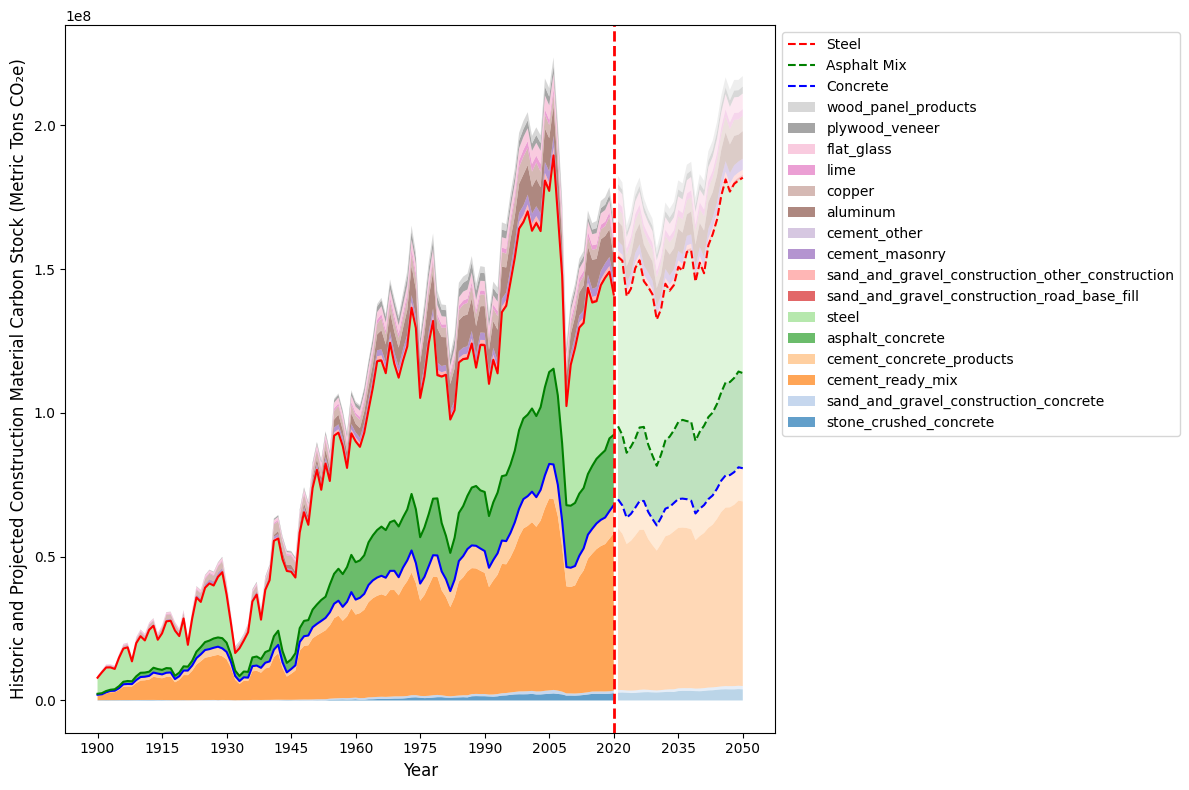

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# Breakdown of sand_and_gravel_construction
filtered_construction_quantity_df['sand_and_gravel_construction_concrete'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.27
filtered_construction_quantity_df['sand_and_gravel_construction_asphalt'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.09
filtered_construction_quantity_df['sand_and_gravel_construction_road_base_fill'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.23
filtered_construction_quantity_df['sand_and_gravel_construction_other_construction'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.41

# Breakdown of stone_crushed
filtered_construction_quantity_df['stone_crushed_aggregate'] = filtered_construction_quantity_df['stone_crushed'] * 0.56
filtered_construction_quantity_df['stone_crushed_concrete'] = (
    filtered_construction_quantity_df['stone_crushed_aggregate'] 
    - (filtered_construction_quantity_df['sand_and_gravel_construction_asphalt'] 
    + 0.95 * filtered_construction_quantity_df['asphalt_concrete'])
)

# Repeat breakdown calculations for projection DataFrame
filtered_construction_projection_df['sand_and_gravel_construction_concrete'] = filtered_construction_projection_df['sand_and_gravel_construction'] * 0.27
filtered_construction_projection_df['sand_and_gravel_construction_asphalt'] = filtered_construction_projection_df['sand_and_gravel_construction'] * 0.09
filtered_construction_projection_df['sand_and_gravel_construction_road_base_fill'] = filtered_construction_projection_df['sand_and_gravel_construction'] * 0.23
filtered_construction_projection_df['sand_and_gravel_construction_other_construction'] = filtered_construction_projection_df['sand_and_gravel_construction'] * 0.41
filtered_construction_projection_df['stone_crushed_aggregate'] = filtered_construction_projection_df['stone_crushed'] * 0.56
filtered_construction_projection_df['stone_crushed_concrete'] = (
    filtered_construction_projection_df['stone_crushed_aggregate'] 
    - (filtered_construction_projection_df['sand_and_gravel_construction_asphalt'] 
    + 0.95 * filtered_construction_projection_df['asphalt_concrete'])
)

# Now apply the MBCI factors
mbci_dict = ghg_inventory.set_index('material')['mbci_a1_to_a3'].to_dict()

for material in filtered_construction_quantity_df.columns:
    if material in mbci_dict:
        filtered_construction_quantity_df[material] *= mbci_dict[material]

for material in filtered_construction_projection_df.columns:
    if material in mbci_dict:
        filtered_construction_projection_df[material] *= mbci_dict[material]

# Calculate aggregated lines
filtered_construction_quantity_df['concrete'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products']].sum(axis=1)
)
filtered_construction_quantity_df['asphalt_mix'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete']].sum(axis=1)
)
filtered_construction_quantity_df['steel_line'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel']].sum(axis=1)
)

# Repeat for projection DataFrame
filtered_construction_projection_df['concrete'] = (
    filtered_construction_projection_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products']].sum(axis=1)
)
filtered_construction_projection_df['asphalt_mix'] = (
    filtered_construction_projection_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete']].sum(axis=1)
)
filtered_construction_projection_df['steel_line'] = (
    filtered_construction_projection_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel']].sum(axis=1)
)

# Define columns to plot with the specified order
columns_to_plot = [
    'stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel',
    'sand_and_gravel_construction_road_base_fill', 'sand_and_gravel_construction_other_construction', 'cement_masonry', 'cement_other', 
    'aluminum', 'copper', 'lime', 'flat_glass', 'lumber', 'plywood_veneer', 'wood_panel_products'
]

# Ensure 'year' is set as the index for both historical and projection data
if 'year' in filtered_construction_quantity_df.columns:
    filtered_construction_quantity_df = filtered_construction_quantity_df.set_index('year')

if 'year' in filtered_construction_projection_df.columns:
    filtered_construction_projection_df = filtered_construction_projection_df.set_index('year')

# Filter columns that exist in both DataFrames
valid_columns = [col for col in columns_to_plot if col in filtered_construction_quantity_df.columns and col in filtered_construction_projection_df.columns]

# Extract data for the valid columns only
stacked_area_data_historic = filtered_construction_quantity_df[valid_columns]
stacked_area_data_projected = filtered_construction_projection_df[valid_columns]

# Set up colors and plot
colors = plt.get_cmap('tab20').colors[:len(valid_columns)]

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plot the stacked area chart for historic data (more opaque)
plt.stackplot(stacked_area_data_historic.index, stacked_area_data_historic.T, labels=valid_columns, colors=colors, alpha=0.7)

# Overlay the stacked area chart for projected data (less opaque)
plt.stackplot(stacked_area_data_projected.index, stacked_area_data_projected.T, colors=colors, alpha=0.3)

# Add additional lines for the aggregated variables
plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['concrete'], label='', color='blue', linewidth=1.5)
plt.plot(filtered_construction_projection_df.index, filtered_construction_projection_df['concrete'], label='Concrete', color='blue', linestyle='--')

plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['asphalt_mix'], label='', color='green', linewidth=1.5)
plt.plot(filtered_construction_projection_df.index, filtered_construction_projection_df['asphalt_mix'], label='Asphalt Mix', color='green', linestyle='--')

plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['steel_line'], label='', color='red', linewidth=1.5)
plt.plot(filtered_construction_projection_df.index, filtered_construction_projection_df['steel_line'], label='Steel', color='red', linestyle='--')

# Add a vertical line at the year 2020
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation above the vertical line
plt.annotate('Projections', xy=(2025, max_total_us * 1.05), xytext=(2035, max_total_us * 1.05),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Customize x-axis
plt.xticks(range(1900, 2051, 15))

# Reverse the legend entries order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove gridlines
plt.grid(False)

# Customize the plot title, x and y labels
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Historic and Projected Construction Material Carbon Stock (Metric Tons CO₂e)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


Contribution:

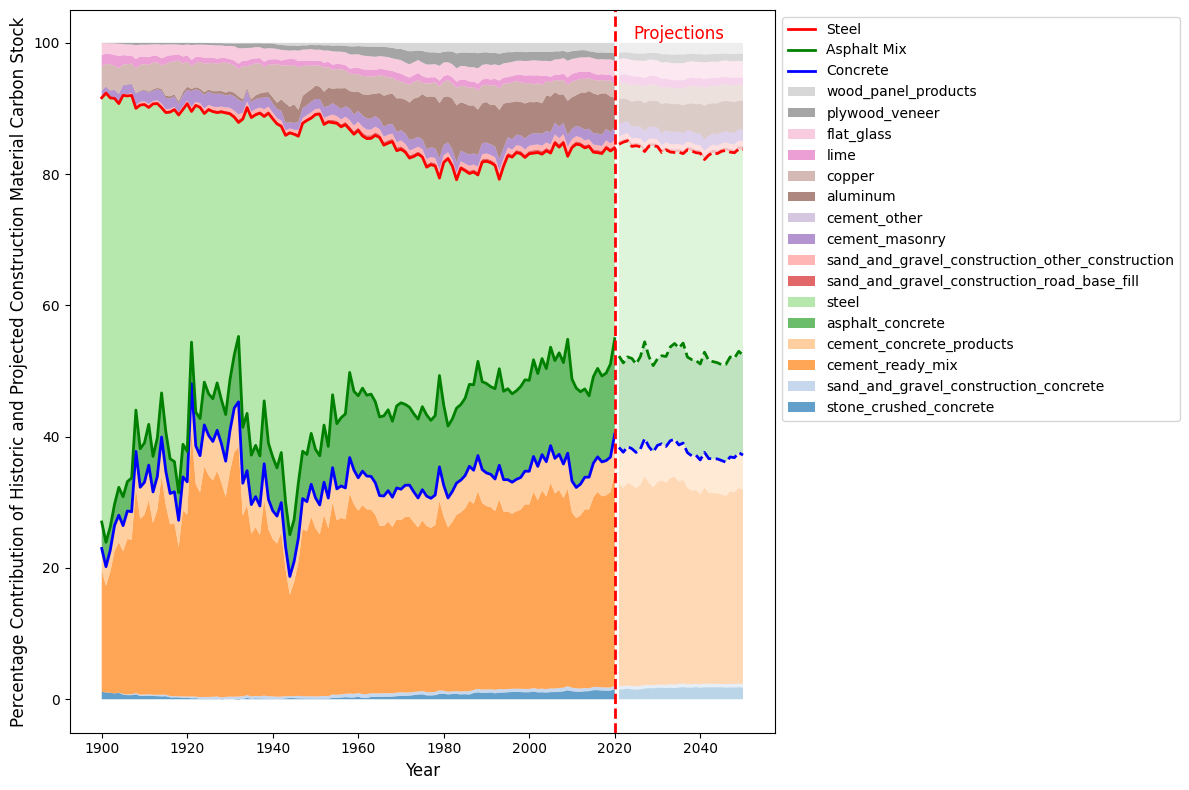

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the percentage contributions for each year in the historic and projected dataframes
stacked_area_data_historic_normalized = stacked_area_data_historic.div(stacked_area_data_historic.sum(axis=1), axis=0) * 100
stacked_area_data_projected_normalized = stacked_area_data_projected.div(stacked_area_data_projected.sum(axis=1), axis=0) * 100

# Normalize the concrete, asphalt, and steel lines to percentage contributions
concrete_historic_normalized = filtered_construction_quantity_df['concrete'] / filtered_construction_quantity_df[valid_columns].sum(axis=1) * 100
asphalt_historic_normalized = filtered_construction_quantity_df['asphalt_mix'] / filtered_construction_quantity_df[valid_columns].sum(axis=1) * 100
steel_historic_normalized = filtered_construction_quantity_df['steel_line'] / filtered_construction_quantity_df[valid_columns].sum(axis=1) * 100

concrete_projected_normalized = filtered_construction_projection_df['concrete'] / filtered_construction_projection_df[valid_columns].sum(axis=1) * 100
asphalt_projected_normalized = filtered_construction_projection_df['asphalt_mix'] / filtered_construction_projection_df[valid_columns].sum(axis=1) * 100
steel_projected_normalized = filtered_construction_projection_df['steel_line'] / filtered_construction_projection_df[valid_columns].sum(axis=1) * 100

# Define the colors to match the material categories
colors = plt.get_cmap('tab20').colors[:len(valid_columns)]

# Create the figure and plot
plt.figure(figsize=(12, 8))

# Plot the 100% stacked bar chart for historic data
plt.stackplot(stacked_area_data_historic_normalized.index, stacked_area_data_historic_normalized.T, labels=valid_columns, colors=colors, alpha=0.7)

# Overlay the 100% stacked bar chart for projected data
plt.stackplot(stacked_area_data_projected_normalized.index, stacked_area_data_projected_normalized.T, colors=colors, alpha=0.3)

# Add concrete, asphalt, and steel lines
plt.plot(concrete_historic_normalized.index, concrete_historic_normalized, label='Concrete', color='blue', linewidth=2)
plt.plot(concrete_projected_normalized.index, concrete_projected_normalized, label='', color='blue', linestyle='--', linewidth=2)

plt.plot(asphalt_historic_normalized.index, asphalt_historic_normalized, label='Asphalt Mix', color='green', linewidth=2)
plt.plot(asphalt_projected_normalized.index, asphalt_projected_normalized, label='', color='green', linestyle='--', linewidth=2)

plt.plot(steel_historic_normalized.index, steel_historic_normalized, label='Steel', color='red', linewidth=2)
plt.plot(steel_projected_normalized.index, steel_projected_normalized, label='', color='red', linestyle='--', linewidth=2)

# Add a vertical line at the year 2020 to separate historic and projected data
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation for projections
plt.annotate('Projections', xy=(2025, 100), xytext=(2035, 100),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Set up plot labels, title, and legend
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Contribution of Historic and Projected Construction Material Carbon Stock', fontsize=12)

# Reverse legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove gridlines for a cleaner look
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


##### Fit line to future projections

Best model for cement_ready_mix: Exponential, Coefficients = [5.57434269e-03 6.73124633e+00], R2 = 0.5161, mse=12893098881531.9336
Best model for cement_concrete_products: Exponential, Coefficients = [0.00557465 5.01698007], R2 = 0.5161, mse=418670553497.9907
Best model for cement_masonry: Exponential, Coefficients = [0.00557456 3.90840308], R2 = 0.5161, mse=45586656573.4703
Best model for cement_other: Exponential, Coefficients = [0.00557446 5.413073  ], R2 = 0.5161, mse=923836836096.5776
Best model for steel: Exponential, Coefficients = [0.00768668 2.75811483], R2 = 0.4734, mse=56510355107859.0547
Best model for aluminum: Exponential, Coefficients = [ 1.69220403e-02 -1.90505329e+01], R2 = 0.8695, mse=84639155749.3053
Best model for copper: Exponential, Coefficients = [ 0.01043414 -6.67220035], R2 = 0.7552, mse=13412646197.4637
Best model for lime: Exponential, Coefficients = [2.20836093e-03 1.20996663e+01], R2 = 0.2770, mse=271935423408.1241
Best model for sand_and_gravel_constructio

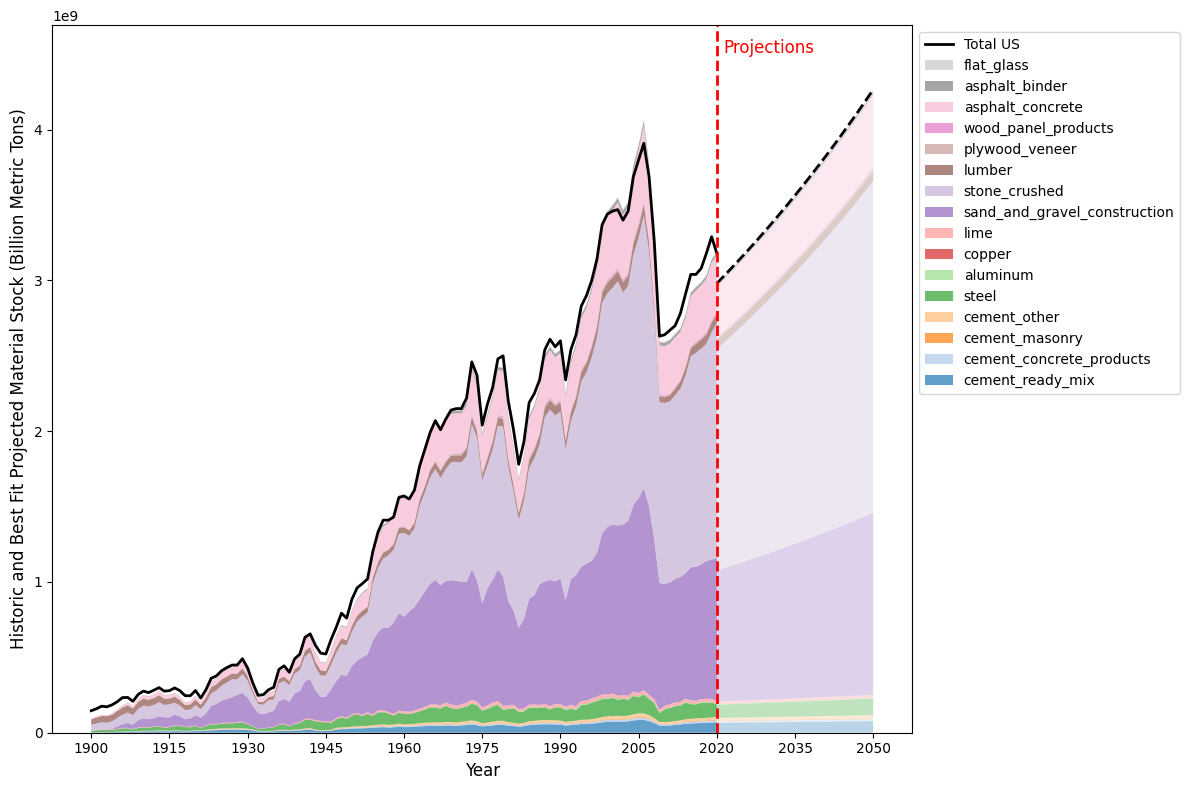

In [154]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load historical and projection data, ensuring "year" is treated as a regular column
projection_df = pd.read_csv('./Output Data/material_projections.csv')

# Ensure 'year' is set as the index
projection_df.set_index("year", inplace=True)

# Identify common columns between the two dataframes
common_columns = projection_df.columns.intersection(historic_data_filled.columns)

# Extract the 2020 row from historic_data_filled for only the common columns
historic_2020 = historic_data_filled.loc[2020, common_columns].to_frame().T

# Ensure the year is set correctly
historic_2020.index = [2020]

# Append the 2020 row to projection_df
projection_df = pd.concat([historic_2020, projection_df], axis=0)

# Ensure 'year' is reset as a column before setting it again as the index
if "year" not in projection_df.columns:
    projection_df.reset_index(inplace=True)

# Ensure the column is explicitly named 'year'
projection_df.rename(columns={"index": "year"}, inplace=True)

# If 'year' is not in columns after renaming, print a debug message
if "year" not in projection_df.columns:
    print("DEBUG: 'year' column is still missing after reset and rename.")
    print(projection_df.head())  # Print first few rows to inspect structure


# Check if "year" is in columns or index, and reset it if necessary
if 'year' not in historic_data_filled.columns:
    historic_data_filled.reset_index(inplace=True)


# Set "year" as the index for both historical and projection data
historic_data_filled.set_index('year', inplace=True)
projection_df.set_index('year', inplace=True)

# Define columns for the stacked area plot
material_columns_for_stack = [
    'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed', 
    'lumber', 'plywood_veneer', 'wood_panel_products', 
    'asphalt_concrete', 'asphalt_binder', 'flat_glass'
]

# DataFrame to store best-fit projections
fitted_projection_df = pd.DataFrame(index=projection_df.index)

# Define function for exponential, logarithmic, and power fit
def exponential_fit(x, y):
    try:
        coeffs = np.polyfit(x, np.log(y), 1)
        y_fit = np.exp(coeffs[1]) * np.exp(coeffs[0] * x)
        return y_fit, mean_squared_error(y, y_fit), r2_score(y, y_fit), "Exponential", coeffs
    except:
        return None, float("inf"), float("inf"), None, None

def logarithmic_fit(x, y):
    try:
        coeffs = np.polyfit(np.log(x), y, 1)
        y_fit = coeffs[0] * np.log(x) + coeffs[1]
        return y_fit, mean_squared_error(y, y_fit), r2_score(y, y_fit), "Logarithmic", coeffs
    except:
        return None, float("inf"), float("inf"), None, None

def power_fit(x, y):
    try:
        coeffs = np.polyfit(np.log(x), np.log(y), 1)
        y_fit = np.exp(coeffs[1]) * x**coeffs[0]
        return y_fit, mean_squared_error(y, y_fit), r2_score(y, y_fit), "Power", coeffs
    except:
        return None, float("inf"), float("inf"), None, None

# Loop through each material to find the best model
for material in material_columns_for_stack:
    y = projection_df[material].values
    x = projection_df.index.values

    best_r2 = -float("inf") # changed to negative infinity, because higher r2 is better.
    best_fit = None
    best_model = None
    best_coeffs = None
    best_mse = None #added to capture the mse if needed.

    # Polynomial fits of different degrees (1 = linear, 2 = quadratic, 3 = cubic)
    for degree in range(1, 2):
        coeffs = np.polyfit(x, y, degree)
        y_fit = np.polyval(coeffs, x)

        mse = mean_squared_error(y, y_fit)
        r2 = r2_score(y, y_fit)

        if r2 > best_r2: # changed to r2 > best_r2
            best_mse = mse #capture the mse
            best_r2 = r2
            best_fit = y_fit
            best_model = f"Polynomial (Degree {degree})"
            best_coeffs = coeffs

    # Exponential, Logarithmic, and Power fits
    for fit_func in [exponential_fit, logarithmic_fit, power_fit]:
        y_fit, mse, r2, model_name, coeffs = fit_func(x, y)
        if y_fit is not None and r2 > best_r2: # changed to r2 > best_r2
            best_mse = mse #capture the mse
            best_r2 = r2
            best_fit = y_fit
            best_model = model_name
            best_coeffs = coeffs

    # Store the best fit line for this material in the fitted projection DataFrame
    fitted_projection_df[material] = best_fit

    # Print the best model parameters and R2 value
    print(f"Best model for {material}: {best_model}, Coefficients = {best_coeffs}, R2 = {best_r2:.4f}, mse={best_mse:.4f}")

# Define total_us for historical and best-fit projections after calculating individual fits
fitted_projection_total_us = fitted_projection_df.sum(axis=1)
fitted_projection_df['total_us'] = fitted_projection_total_us

# Save the best-fit projections to a new CSV file
fitted_projection_df.to_csv('./Output Data/material_projections_best_fit.csv')

# Define total_us for historical and best-fit projections
total_us_data_historic = historic_data_filled['total_us']
fitted_projection_total_us = fitted_projection_df[material_columns_for_stack].sum(axis=1)

# Plotting
max_total_us = max(total_us_data_historic.max(), fitted_projection_total_us.max())
colors = plt.get_cmap('tab20').colors[:len(material_columns_for_stack)]

plt.figure(figsize=(12, 8))

# Plot the stacked area chart for the historical data (more opaque)
plt.stackplot(historic_data_filled.index, historic_data_filled[material_columns_for_stack].T, labels=material_columns_for_stack, colors=colors, alpha=0.7)

# Overlay the stacked area chart for the best-fit projections (same colors, less opaque)
plt.stackplot(fitted_projection_df.index, fitted_projection_df[material_columns_for_stack].T, colors=colors, alpha=0.3)

# Plot the 'total_us' line for historical and best-fit projected data
plt.plot(total_us_data_historic.index, total_us_data_historic.values, label='Total US', color='black', linewidth=2)
plt.plot(fitted_projection_total_us.index, fitted_projection_total_us.values, label='', color='black', linewidth=2, linestyle='--')

# Add a vertical line at the year 2020 to indicate when projections start
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add annotation above the vertical line
plt.annotate('Projections', xy=(2025, max_total_us * 1.05), xytext=(2030, max_total_us * 1.05),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Adjust y-axis
plt.ylim(0, max_total_us * 1.1)

# Customize x-axis
plt.xticks(range(1900, 2051, 15))

# Reverse the legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Final plot customizations
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Historic and Best Fit Projected Material Stock (Billion Metric Tons)', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()



###### Construction share (based on fitted projection to ARIMAX)

Historic.

In [155]:
import pandas as pd

# Load the projection and construction share data
construction_historic_df = historic_data_filled.reset_index()  # Reset index to ensure 'year' is a column

# List of columns to modify
columns_to_plot = [
    'total_us', 'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed',
    'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 'asphalt_binder', 'flat_glass'
]

# Fill missing values in construction_share with the median for each column
construction_share_filled = construction_share.set_index('year').copy()  # Set 'year' as the index
for column in columns_to_plot:
    if column in construction_share.columns:
        median_value = construction_share[column].median()
        # Fill missing values with the median
        construction_share_filled[column].fillna(median_value, inplace=True)
    else:
        print(f"Warning: {column} not found in construction_share.")

# Multiply each year's data in construction_historic_df by the corresponding values in construction_share_filled
for column in columns_to_plot:
    if column in construction_historic_df.columns and column in construction_share_filled.columns:
        # Reindex to align with construction_historic_df's year values
        construction_historic_df[column] = (
            construction_historic_df[column] * construction_share_filled[column].reindex(construction_historic_df['year']).values
        )

# Ensure 'year' is included in the final DataFrame and keep only valid columns
filtered_construction_quantity_df = construction_historic_df[['year'] + columns_to_plot]

# Save the modified DataFrame to a new CSV file
output_path = './Output Data/construction_material_historic.csv'
filtered_construction_quantity_df.to_csv(output_path, index=False)

print(f"New file saved at: {output_path}")


New file saved at: ./Output Data/construction_material_historic.csv


Projections:

In [156]:
import pandas as pd

# Load the projection and construction share data
construction_projection_df_best_fit = pd.read_csv('./Output Data/material_projections_best_fit.csv')

# List of columns to modify
columns_to_plot = [
    'total_us', 'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed',
    'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 'asphalt_binder', 'flat_glass'
]

# Identify the last available value for each specified column in construction_share, skipping columns with all NaNs
last_available_values = {}
for column in columns_to_plot:
    non_na_values = construction_share[column].dropna()
    if not non_na_values.empty:
        last_available_values[column] = non_na_values.iloc[-1]  # Use the last non-NaN value

# Filter out columns where there is no available value (i.e., all values are NaN)
valid_columns = list(last_available_values.keys())
filtered_last_values = pd.Series(last_available_values)

# Multiply each valid column in construction_projection_df_best_fit by the corresponding last available value
for column in valid_columns:
    construction_projection_df_best_fit[column] = construction_projection_df_best_fit[column] * filtered_last_values[column]

# Keep only the 'year' column and the valid columns in the final DataFrame
filtered_construction_projection_df_best_fit = construction_projection_df_best_fit[['year'] + valid_columns]

# Save the modified DataFrame to a new CSV file
output_path = './Output Data/construction_material_projections_best_fit.csv'
filtered_construction_projection_df_best_fit.to_csv(output_path, index=False)

print(f"New file saved at: {output_path}")


New file saved at: ./Output Data/construction_material_projections_best_fit.csv


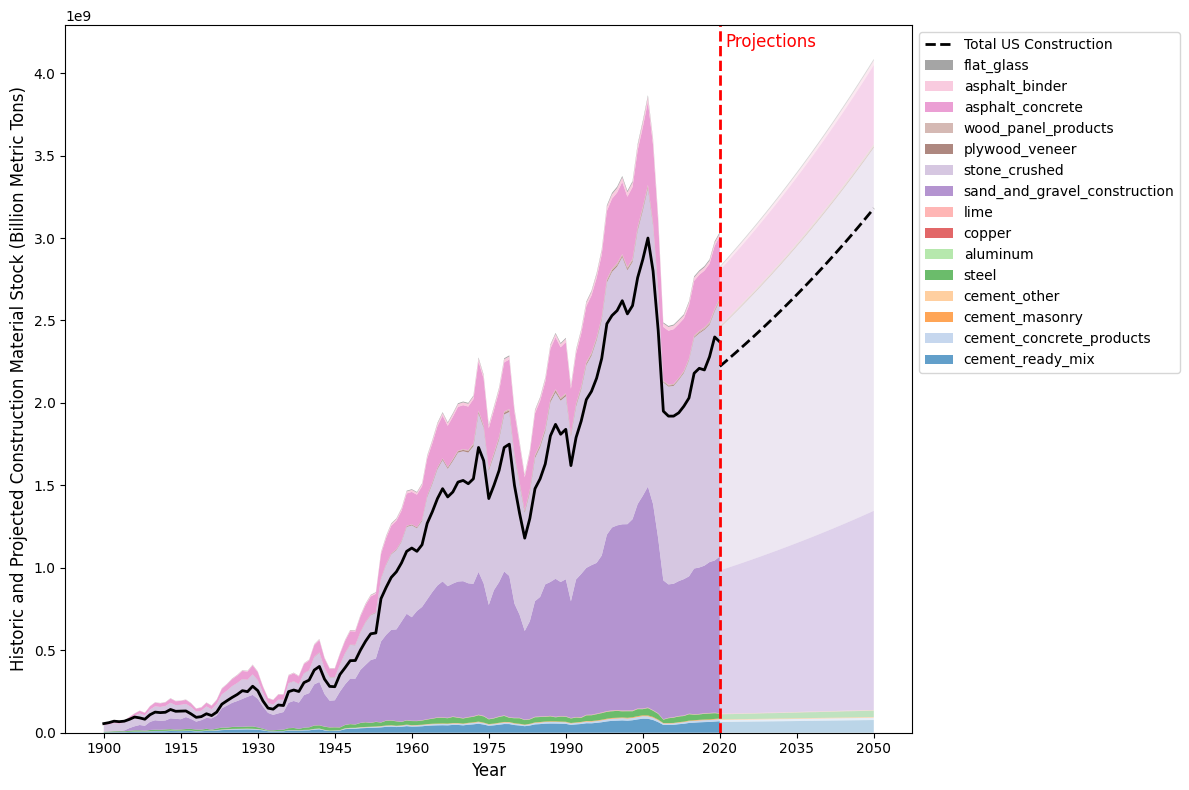

In [157]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns for the stacked area plot
columns_to_plot = [
    'cement_ready_mix', 'cement_concrete_products', 'cement_masonry', 'cement_other', 
    'steel', 'aluminum', 'copper', 'lime', 'sand_and_gravel_construction', 'stone_crushed',
    'lumber', 'plywood_veneer', 'wood_panel_products', 'asphalt_concrete', 'asphalt_binder', 'flat_glass'
]

# Ensure 'year' is set as the index for both historical and projection data
if 'year' in filtered_construction_quantity_df.columns:
    filtered_construction_quantity_df = filtered_construction_quantity_df.set_index('year')

if 'year' in filtered_construction_projection_df_best_fit.columns:
    filtered_construction_projection_df_best_fit = filtered_construction_projection_df_best_fit.set_index('year')

# Filter columns that exist in both DataFrames
valid_columns = [col for col in columns_to_plot if col in filtered_construction_quantity_df.columns and col in filtered_construction_projection_df_best_fit.columns]

# Extract data for the valid columns only
stacked_area_data_historic = filtered_construction_quantity_df[valid_columns]
stacked_area_data_projected_best_fit = filtered_construction_projection_df_best_fit[valid_columns]

# Extract 'total_us' data for both historic and projected data if available
if 'total_us' in filtered_construction_quantity_df.columns and 'total_us' in filtered_construction_projection_df_best_fit.columns:
    total_us_data_historic = filtered_construction_quantity_df['total_us']
    total_us_data_projected_best_fit = filtered_construction_projection_df_best_fit['total_us']
    max_total_us = max(total_us_data_historic.max(), total_us_data_projected_best_fit.max())
else:
    print("Warning: 'total_us' column not found in one of the datasets.")
    max_total_us = max(stacked_area_data_historic.sum(axis=1).max(), stacked_area_data_projected_best_fit.sum(axis=1).max())

# Set up colors and plot
colors = plt.get_cmap('tab20').colors[:len(valid_columns)]

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plot the stacked area chart for historic data (more opaque)
plt.stackplot(stacked_area_data_historic.index, stacked_area_data_historic.T, labels=valid_columns, colors=colors, alpha=0.7)

# Overlay the stacked area chart for projected data (less opaque)
plt.stackplot(stacked_area_data_projected_best_fit.index, stacked_area_data_projected_best_fit.T, colors=colors, alpha=0.3)

# Plot the 'total_us' line for historic and projected data if it exists
if 'total_us' in filtered_construction_quantity_df.columns and 'total_us' in filtered_construction_projection_df_best_fit.columns:
    plt.plot(total_us_data_historic.index, total_us_data_historic.values, label='', color='black', linewidth=2)
    plt.plot(total_us_data_projected_best_fit.index, total_us_data_projected_best_fit.values, label='Total US Construction', color='black', linewidth=2, linestyle='--')

# Add a vertical line at the year 2020
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation above the vertical line
plt.annotate('Projections', xy=(2025, max_total_us * 1.3), xytext=(2030, max_total_us * 1.3),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Customize x-axis
plt.xticks(range(1900, 2051, 15))

# Reverse the legend entries order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove gridlines
plt.grid(False)

# Customize the plot
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Historic and Projected Construction Material Stock (Billion Metric Tons)', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


###### Construction material recategorization

Assumptions:

* Concrete:
    - The rest of crushed stone not in hma is in concrete
    - average cement mass % = 12%
    - average water-to-cement ratio = 0.45
    - average aggregate content = 81%


* Asphalt:
    - average asphalt binder content = 3.5% (if needed)
    - average rap content in 2020 = 20% (if needed)


 * `sand_and_gravel_construction`:
    - "_concrete" equals 27% of sand_and_gravel_construction
    - "_asphalt" equals 9% of sand_and_gravel_construction
    - "_road_base_fill" equals 23% of sand_and_gravel_construction
    - "_other_construction" equals 41% of sand_and_gravel_construction

* `stone_crushed`:
    - "_no_construction" = 44%
    - "_aggregate" = 56%

* Steel:
    - Percent of total steel used in construction = 35%

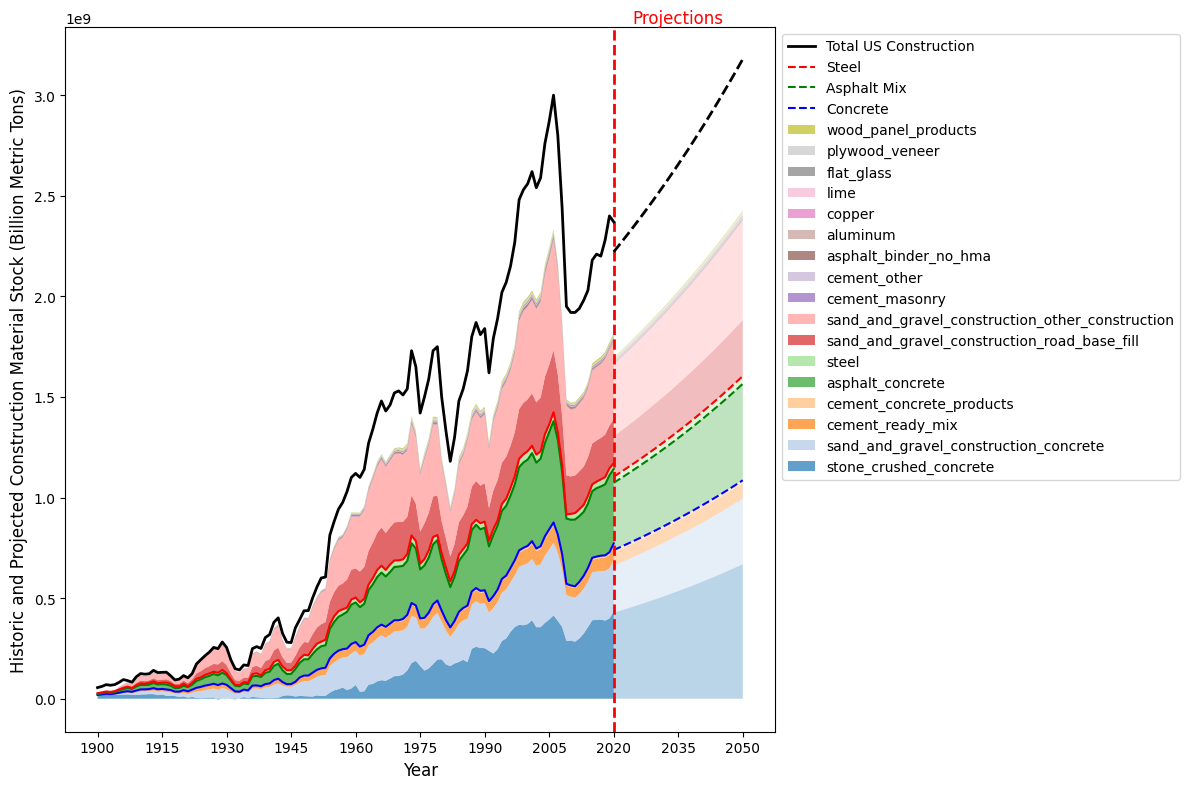

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Breakdown of sand_and_gravel_construction
filtered_construction_quantity_df['sand_and_gravel_construction_concrete'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.27
filtered_construction_quantity_df['sand_and_gravel_construction_asphalt'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.09
filtered_construction_quantity_df['sand_and_gravel_construction_road_base_fill'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.23
filtered_construction_quantity_df['sand_and_gravel_construction_other_construction'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.41

# Breakdown of stone_crushed
filtered_construction_quantity_df['stone_crushed_aggregate'] = filtered_construction_quantity_df['stone_crushed'] * 0.56

# Asphalt binder not in HMA
average_asphalt_binder_content = 0.035
filtered_construction_quantity_df['asphalt_binder_no_hma'] = filtered_construction_quantity_df['asphalt_binder'] - filtered_construction_quantity_df['asphalt_concrete'] * average_asphalt_binder_content

# Calculate stone_crushed_concrete
filtered_construction_quantity_df['stone_crushed_concrete'] = (
    filtered_construction_quantity_df['stone_crushed_aggregate'] 
    - (filtered_construction_quantity_df['sand_and_gravel_construction_asphalt'] 
    + 0.95 * filtered_construction_quantity_df['asphalt_concrete'])
)

# Repeat calculations for projection DataFrame
filtered_construction_projection_df_best_fit['sand_and_gravel_construction_concrete'] = filtered_construction_projection_df_best_fit['sand_and_gravel_construction'] * 0.27
filtered_construction_projection_df_best_fit['sand_and_gravel_construction_asphalt'] = filtered_construction_projection_df_best_fit['sand_and_gravel_construction'] * 0.09
filtered_construction_projection_df_best_fit['sand_and_gravel_construction_road_base_fill'] = filtered_construction_projection_df_best_fit['sand_and_gravel_construction'] * 0.23
filtered_construction_projection_df_best_fit['sand_and_gravel_construction_other_construction'] = filtered_construction_projection_df_best_fit['sand_and_gravel_construction'] * 0.41

filtered_construction_projection_df_best_fit['stone_crushed_aggregate'] = filtered_construction_projection_df_best_fit['stone_crushed'] * 0.56
filtered_construction_projection_df_best_fit['stone_crushed_concrete'] = (
    filtered_construction_projection_df_best_fit['stone_crushed_aggregate'] 
    - (filtered_construction_projection_df_best_fit['sand_and_gravel_construction_asphalt'] 
    + 0.95 * filtered_construction_projection_df_best_fit['asphalt_concrete'])
)

# Asphalt binder other than in HMA
filtered_construction_projection_df_best_fit['asphalt_binder_no_hma'] = filtered_construction_projection_df_best_fit['asphalt_binder'] - filtered_construction_projection_df_best_fit['asphalt_concrete'] * average_asphalt_binder_content

# Calculate new line variables
filtered_construction_quantity_df['concrete'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products']].sum(axis=1)
)
filtered_construction_quantity_df['asphalt_mix'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete']].sum(axis=1)
)
filtered_construction_quantity_df['steel_line'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel']].sum(axis=1)
)

# Repeat for projection DataFrame
filtered_construction_projection_df_best_fit['concrete'] = (
    filtered_construction_projection_df_best_fit[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products']].sum(axis=1)
)
filtered_construction_projection_df_best_fit['asphalt_mix'] = (
    filtered_construction_projection_df_best_fit[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete']].sum(axis=1)
)
filtered_construction_projection_df_best_fit['steel_line'] = (
    filtered_construction_projection_df_best_fit[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel']].sum(axis=1)
)

# Define columns to plot with the specified order
columns_to_plot = [
    'stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel',
    'sand_and_gravel_construction_road_base_fill', 'sand_and_gravel_construction_other_construction', 'cement_masonry', 'cement_other', 'asphalt_binder_no_hma',
    'aluminum', 'copper', 'lime', 'flat_glass', 'lumber', 'plywood_veneer', 'wood_panel_products'
]

# Ensure 'year' is set as the index for both historical and projection data
if 'year' in filtered_construction_quantity_df.columns:
    filtered_construction_quantity_df = filtered_construction_quantity_df.set_index('year')

if 'year' in filtered_construction_projection_df_best_fit.columns:
    filtered_construction_projection_df_best_fit = filtered_construction_projection_df_best_fit.set_index('year')

# Filter columns that exist in both DataFrames
valid_columns = [col for col in columns_to_plot if col in filtered_construction_quantity_df.columns and col in filtered_construction_projection_df_best_fit.columns]

# Extract data for the valid columns only
stacked_area_data_historic = filtered_construction_quantity_df[valid_columns]
stacked_area_data_projected_best_fit = filtered_construction_projection_df_best_fit[valid_columns]

# Set up colors and plot
colors = plt.get_cmap('tab20').colors[:len(valid_columns)]

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plot the stacked area chart for historic data (more opaque)
plt.stackplot(stacked_area_data_historic.index, stacked_area_data_historic.T, labels=valid_columns, colors=colors, alpha=0.7)

# Overlay the stacked area chart for projected data (less opaque)
plt.stackplot(stacked_area_data_projected_best_fit.index, stacked_area_data_projected_best_fit.T, colors=colors, alpha=0.3)

# Add additional lines for the new variables
plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['concrete'], label='', color='blue', linewidth=1.5)
plt.plot(filtered_construction_projection_df_best_fit.index, filtered_construction_projection_df_best_fit['concrete'], label='Concrete', color='blue', linestyle='--')

plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['asphalt_mix'], label='', color='green', linewidth=1.5)
plt.plot(filtered_construction_projection_df_best_fit.index, filtered_construction_projection_df_best_fit['asphalt_mix'], label='Asphalt Mix', color='green', linestyle='--')

plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['steel_line'], label='', color='red', linewidth=1.5)
plt.plot(filtered_construction_projection_df_best_fit.index, filtered_construction_projection_df_best_fit['steel_line'], label='Steel', color='red', linestyle='--')

# Add a vertical line at the year 2020
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation above the vertical line
plt.annotate('Projections', xy=(2025, max_total_us * 1.05), xytext=(2035, max_total_us * 1.05),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Plot the 'total_us' line for historic and projected data if it exists
if 'total_us' in filtered_construction_quantity_df.columns and 'total_us' in filtered_construction_projection_df_best_fit.columns:
    plt.plot(total_us_data_historic.index, total_us_data_historic.values, label='Total US Construction', color='black', linewidth=2)
    plt.plot(total_us_data_projected_best_fit.index, total_us_data_projected_best_fit.values, label='', color='black', linewidth=2, linestyle='--')


# Customize x-axis
plt.xticks(range(1900, 2051, 15))

# Reverse the legend entries order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove gridlines
plt.grid(False)

# Customize the plot
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Historic and Projected Construction Material Stock (Billion Metric Tons)', fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


Extract data:

In [159]:
columns_to_extract = [
    'stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel',
    'sand_and_gravel_construction_road_base_fill', 'sand_and_gravel_construction_other_construction', 'cement_masonry', 'asphalt_binder_no_hma',
    'aluminum', 'copper', 'lime', 'flat_glass', 'plywood_veneer', 'wood_panel_products'
]

filtered_construction_projection_df_best_fit[columns_to_extract].head()

filtered_construction_projection_df_best_fit[columns_to_extract].to_excel('./Output Data/approach1_construction_quantities.xlsx')

In [160]:
total_us_data_projected_best_fit.to_excel('./Output Data/total_us_data_projected_best_fit_quantity.xlsx')

In [161]:
filtered_construction_projection_df_best_fit.head(50)

,total_us,cement_ready_mix,cement_concrete_products,cement_masonry,cement_other,steel,aluminum,copper,lime,sand_and_gravel_construction,...,sand_and_gravel_construction_concrete,sand_and_gravel_construction_asphalt,sand_and_gravel_construction_road_base_fill,sand_and_gravel_construction_other_construction,stone_crushed_aggregate,stone_crushed_concrete,asphalt_binder_no_hma,concrete,asphalt_mix,steel_line
year,,,,,,,,,,,,,,,,,,,,,
2020,2.221496e+09,6.509892e+07,1.173132e+07,3.870956e+06,0.0,3.056534e+07,596963.309648,8.652673e+05,2.023490e+06,8.691943e+08,...,2.346825e+08,7.822749e+07,1.999147e+08,3.563697e+08,8.234699e+08,4.278298e+08,5.999263e+06,7.393425e+08,1.073461e+09,1.104026e+09
2021,2.248059e+09,6.546282e+07,1.179690e+07,3.892595e+06,0.0,3.080119e+07,607151.102842,8.743429e+05,2.027964e+06,8.787702e+08,...,2.372680e+08,7.908932e+07,2.021172e+08,3.602958e+08,8.346335e+08,4.342831e+08,6.130424e+06,7.488108e+08,1.086980e+09,1.117782e+09
2022,2.274952e+09,6.582875e+07,1.186285e+07,3.914355e+06,0.0,3.103886e+07,617512.761211,8.835137e+05,2.032447e+06,8.884516e+08,...,2.398819e+08,7.996065e+07,2.043439e+08,3.642652e+08,8.459485e+08,4.408316e+08,6.264077e+06,7.584052e+08,1.100675e+09,1.131714e+09
2023,2.302177e+09,6.619673e+07,1.192916e+07,3.936237e+06,0.0,3.127837e+07,628051.251943,8.927806e+05,2.036941e+06,8.982397e+08,...,2.425247e+08,8.084158e+07,2.065951e+08,3.682783e+08,8.574168e+08,4.474767e+08,6.400266e+06,7.681274e+08,1.114547e+09,1.145825e+09
2024,2.329740e+09,6.656676e+07,1.199585e+07,3.958241e+06,0.0,3.151972e+07,638769.592864,9.021448e+05,2.041444e+06,9.081356e+08,...,2.451966e+08,8.173221e+07,2.088712e+08,3.723356e+08,8.690406e+08,4.542198e+08,6.539035e+06,7.779790e+08,1.128599e+09,1.160118e+09
2025,2.357644e+09,6.693886e+07,1.206291e+07,3.980368e+06,0.0,3.176294e+07,649670.853302,9.116072e+05,2.045957e+06,9.181406e+08,...,2.478980e+08,8.263265e+07,2.111723e+08,3.764376e+08,8.808220e+08,4.610623e+08,6.680430e+06,7.879620e+08,1.142833e+09,1.174596e+09
2026,2.385894e+09,6.731305e+07,1.213034e+07,4.002619e+06,0.0,3.200803e+07,660758.154968,9.211688e+05,2.050480e+06,9.282558e+08,...,2.506291e+08,8.354302e+07,2.134988e+08,3.805849e+08,8.927631e+08,4.680056e+08,6.824497e+06,7.980780e+08,1.157251e+09,1.189259e+09
2027,2.414494e+09,6.768932e+07,1.219815e+07,4.024994e+06,0.0,3.225501e+07,672034.672847,9.308307e+05,2.055014e+06,9.384824e+08,...,2.533902e+08,8.446341e+07,2.158509e+08,3.847778e+08,9.048661e+08,4.750512e+08,6.971285e+06,8.083289e+08,1.171857e+09,1.204112e+09
2028,2.443449e+09,6.806770e+07,1.226634e+07,4.047494e+06,0.0,3.250390e+07,683503.636107,9.405940e+05,2.059557e+06,9.488216e+08,...,2.561818e+08,8.539395e+07,2.182290e+08,3.890169e+08,9.171332e+08,4.822005e+08,7.120840e+06,8.187164e+08,1.186652e+09,1.219156e+09


###### Embodied carbon baseline

Now, multiply construction share quantities by embodied carbon (A1 to A3) of them.

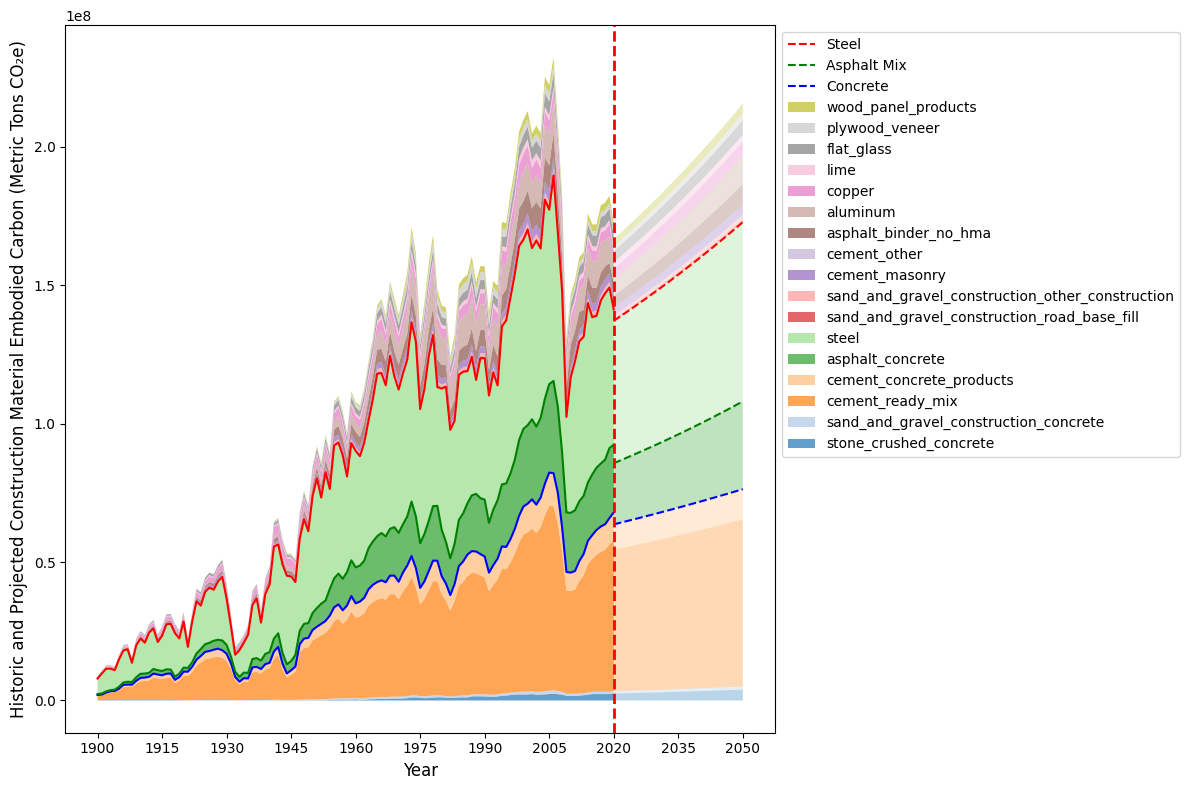

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Breakdown of sand_and_gravel_construction
filtered_construction_quantity_df['sand_and_gravel_construction_concrete'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.27
filtered_construction_quantity_df['sand_and_gravel_construction_asphalt'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.09
filtered_construction_quantity_df['sand_and_gravel_construction_road_base_fill'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.23
filtered_construction_quantity_df['sand_and_gravel_construction_other_construction'] = filtered_construction_quantity_df['sand_and_gravel_construction'] * 0.41

# Breakdown of stone_crushed
filtered_construction_quantity_df['stone_crushed_aggregate'] = filtered_construction_quantity_df['stone_crushed'] * 0.56
filtered_construction_quantity_df['stone_crushed_concrete'] = (
    filtered_construction_quantity_df['stone_crushed_aggregate'] 
    - (filtered_construction_quantity_df['sand_and_gravel_construction_asphalt'] 
    + 0.95 * filtered_construction_quantity_df['asphalt_concrete'])
)

# Repeat breakdown calculations for projection DataFrame
filtered_construction_projection_df_best_fit['sand_and_gravel_construction_concrete'] = filtered_construction_projection_df_best_fit['sand_and_gravel_construction'] * 0.27
filtered_construction_projection_df_best_fit['sand_and_gravel_construction_asphalt'] = filtered_construction_projection_df_best_fit['sand_and_gravel_construction'] * 0.09
filtered_construction_projection_df_best_fit['sand_and_gravel_construction_road_base_fill'] = filtered_construction_projection_df_best_fit['sand_and_gravel_construction'] * 0.23
filtered_construction_projection_df_best_fit['sand_and_gravel_construction_other_construction'] = filtered_construction_projection_df_best_fit['sand_and_gravel_construction'] * 0.41
filtered_construction_projection_df_best_fit['stone_crushed_aggregate'] = filtered_construction_projection_df_best_fit['stone_crushed'] * 0.56
filtered_construction_projection_df_best_fit['stone_crushed_concrete'] = (
    filtered_construction_projection_df_best_fit['stone_crushed_aggregate'] 
    - (filtered_construction_projection_df_best_fit['sand_and_gravel_construction_asphalt'] 
    + 0.95 * filtered_construction_projection_df_best_fit['asphalt_concrete'])
)

# Now apply the MBCI factors
mbci_dict = ghg_inventory.set_index('material')['mbci_a1_to_a3'].to_dict()

for material in filtered_construction_quantity_df.columns:
    if material in mbci_dict:
        filtered_construction_quantity_df[material] *= mbci_dict[material]

for material in filtered_construction_projection_df_best_fit.columns:
    if material in mbci_dict:
        filtered_construction_projection_df_best_fit[material] *= mbci_dict[material]

# Calculate aggregated lines
filtered_construction_quantity_df['concrete'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products']].sum(axis=1)
)
filtered_construction_quantity_df['asphalt_mix'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete']].sum(axis=1)
)
filtered_construction_quantity_df['steel_line'] = (
    filtered_construction_quantity_df[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel']].sum(axis=1)
)

# Repeat for projection DataFrame
filtered_construction_projection_df_best_fit['concrete'] = (
    filtered_construction_projection_df_best_fit[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products']].sum(axis=1)
)
filtered_construction_projection_df_best_fit['asphalt_mix'] = (
    filtered_construction_projection_df_best_fit[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete']].sum(axis=1)
)
filtered_construction_projection_df_best_fit['steel_line'] = (
    filtered_construction_projection_df_best_fit[['stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel']].sum(axis=1)
)

# Define columns to plot with the specified order
columns_to_plot = [
    'stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel',
    'sand_and_gravel_construction_road_base_fill', 'sand_and_gravel_construction_other_construction', 'cement_masonry', 'cement_other', 'asphalt_binder_no_hma',
    'aluminum', 'copper', 'lime', 'flat_glass', 'lumber', 'plywood_veneer', 'wood_panel_products'
]

# Ensure 'year' is set as the index for both historical and projection data
if 'year' in filtered_construction_quantity_df.columns:
    filtered_construction_quantity_df = filtered_construction_quantity_df.set_index('year')

if 'year' in filtered_construction_projection_df_best_fit.columns:
    filtered_construction_projection_df_best_fit = filtered_construction_projection_df_best_fit.set_index('year')

# Filter columns that exist in both DataFrames
valid_columns = [col for col in columns_to_plot if col in filtered_construction_quantity_df.columns and col in filtered_construction_projection_df_best_fit.columns]

# Extract data for the valid columns only
stacked_area_data_historic = filtered_construction_quantity_df[valid_columns]
stacked_area_data_projected_best_fit = filtered_construction_projection_df_best_fit[valid_columns]

# Set up colors and plot
colors = plt.get_cmap('tab20').colors[:len(valid_columns)]

# Create a figure and axis object
plt.figure(figsize=(12, 8))

# Plot the stacked area chart for historic data (more opaque)
plt.stackplot(stacked_area_data_historic.index, stacked_area_data_historic.T, labels=valid_columns, colors=colors, alpha=0.7)

# Overlay the stacked area chart for projected data (less opaque)
plt.stackplot(stacked_area_data_projected_best_fit.index, stacked_area_data_projected_best_fit.T, colors=colors, alpha=0.3)

# Add additional lines for the aggregated variables
plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['concrete'], label='', color='blue', linewidth=1.5)
plt.plot(filtered_construction_projection_df_best_fit.index, filtered_construction_projection_df_best_fit['concrete'], label='Concrete', color='blue', linestyle='--')

plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['asphalt_mix'], label='', color='green', linewidth=1.5)
plt.plot(filtered_construction_projection_df_best_fit.index, filtered_construction_projection_df_best_fit['asphalt_mix'], label='Asphalt Mix', color='green', linestyle='--')

plt.plot(filtered_construction_quantity_df.index, filtered_construction_quantity_df['steel_line'], label='', color='red', linewidth=1.5)
plt.plot(filtered_construction_projection_df_best_fit.index, filtered_construction_projection_df_best_fit['steel_line'], label='Steel', color='red', linestyle='--')

# Add a vertical line at the year 2020
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation above the vertical line
plt.annotate('Projections', xy=(2025, max_total_us * 1.05), xytext=(2035, max_total_us * 1.05),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Customize x-axis
plt.xticks(range(1900, 2051, 15))

# Reverse the legend entries order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove gridlines
plt.grid(False)

# Customize the plot title, x and y labels
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Historic and Projected Construction Material Embodied Carbon (Metric Tons CO₂e)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [163]:
columns_to_extract_co2 = [
    'stone_crushed_concrete', 'sand_and_gravel_construction_concrete', 'cement_ready_mix', 'cement_concrete_products', 'asphalt_concrete', 'steel',
    'sand_and_gravel_construction_road_base_fill', 'sand_and_gravel_construction_other_construction', 'cement_masonry', 'asphalt_binder_no_hma',
    'aluminum', 'copper', 'lime', 'flat_glass', 'plywood_veneer', 'wood_panel_products'
]

stacked_area_data_projected_best_fit[columns_to_extract].head()

stacked_area_data_projected_best_fit[columns_to_extract].to_excel('./Output Data/approach1_construction_co2.xlsx')



Contribution.

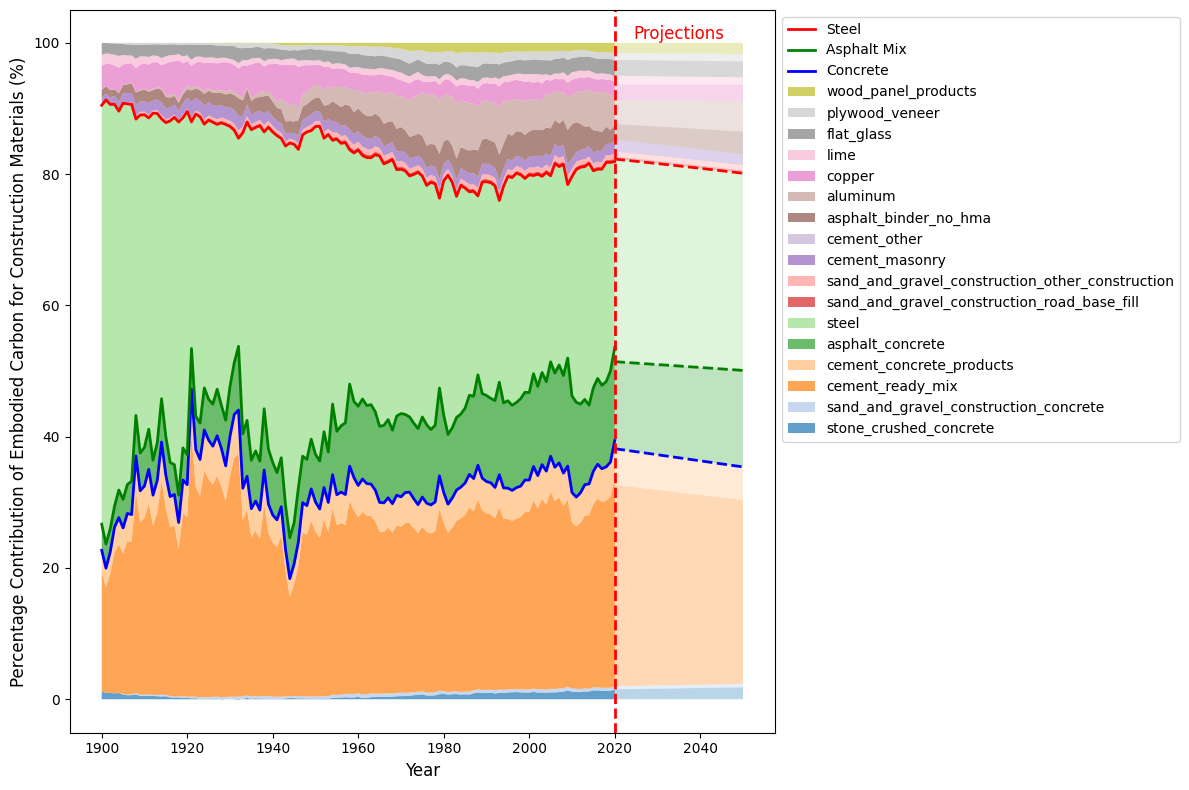

In [164]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the percentage contributions for each year in the historic and projected dataframes
stacked_area_data_historic_normalized = stacked_area_data_historic.div(stacked_area_data_historic.sum(axis=1), axis=0) * 100
stacked_area_data_projected_normalized_best_fit = stacked_area_data_projected_best_fit.div(stacked_area_data_projected_best_fit.sum(axis=1), axis=0) * 100

# Normalize the concrete, asphalt, and steel lines to percentage contributions
concrete_historic_normalized = filtered_construction_quantity_df['concrete'] / filtered_construction_quantity_df[valid_columns].sum(axis=1) * 100
asphalt_historic_normalized = filtered_construction_quantity_df['asphalt_mix'] / filtered_construction_quantity_df[valid_columns].sum(axis=1) * 100
steel_historic_normalized = filtered_construction_quantity_df['steel_line'] / filtered_construction_quantity_df[valid_columns].sum(axis=1) * 100

concrete_projected_normalized = filtered_construction_projection_df_best_fit['concrete'] / filtered_construction_projection_df_best_fit[valid_columns].sum(axis=1) * 100
asphalt_projected_normalized = filtered_construction_projection_df_best_fit['asphalt_mix'] / filtered_construction_projection_df_best_fit[valid_columns].sum(axis=1) * 100
steel_projected_normalized = filtered_construction_projection_df_best_fit['steel_line'] / filtered_construction_projection_df_best_fit[valid_columns].sum(axis=1) * 100

# Define the colors to match the material categories
colors = plt.get_cmap('tab20').colors[:len(valid_columns)]

# Create the figure and plot
plt.figure(figsize=(12, 8))

# Plot the 100% stacked bar chart for historic data
plt.stackplot(stacked_area_data_historic_normalized.index, stacked_area_data_historic_normalized.T, labels=valid_columns, colors=colors, alpha=0.7)

# Overlay the 100% stacked bar chart for projected data
plt.stackplot(stacked_area_data_projected_normalized_best_fit.index, stacked_area_data_projected_normalized_best_fit.T, colors=colors, alpha=0.3)

# Add concrete, asphalt, and steel lines
plt.plot(concrete_historic_normalized.index, concrete_historic_normalized, label='Concrete', color='blue', linewidth=2)
plt.plot(concrete_projected_normalized.index, concrete_projected_normalized, label='', color='blue', linestyle='--', linewidth=2)

plt.plot(asphalt_historic_normalized.index, asphalt_historic_normalized, label='Asphalt Mix', color='green', linewidth=2)
plt.plot(asphalt_projected_normalized.index, asphalt_projected_normalized, label='', color='green', linestyle='--', linewidth=2)

plt.plot(steel_historic_normalized.index, steel_historic_normalized, label='Steel', color='red', linewidth=2)
plt.plot(steel_projected_normalized.index, steel_projected_normalized, label='', color='red', linestyle='--', linewidth=2)

# Add a vertical line at the year 2020 to separate historic and projected data
plt.axvline(x=2020, color='red', linestyle='--', linewidth=2)

# Add an annotation for projections
plt.annotate('Projections', xy=(2025, 100), xytext=(2035, 100),
             textcoords='data', color='red', fontsize=12, ha='center', va='bottom')

# Set up plot labels, title, and legend
plt.title('', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Contribution of Embodied Carbon for Construction Materials (%)', fontsize=12)

# Reverse legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=10)

# Remove gridlines for a cleaner look
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()
